Number of duplicate rows: 29


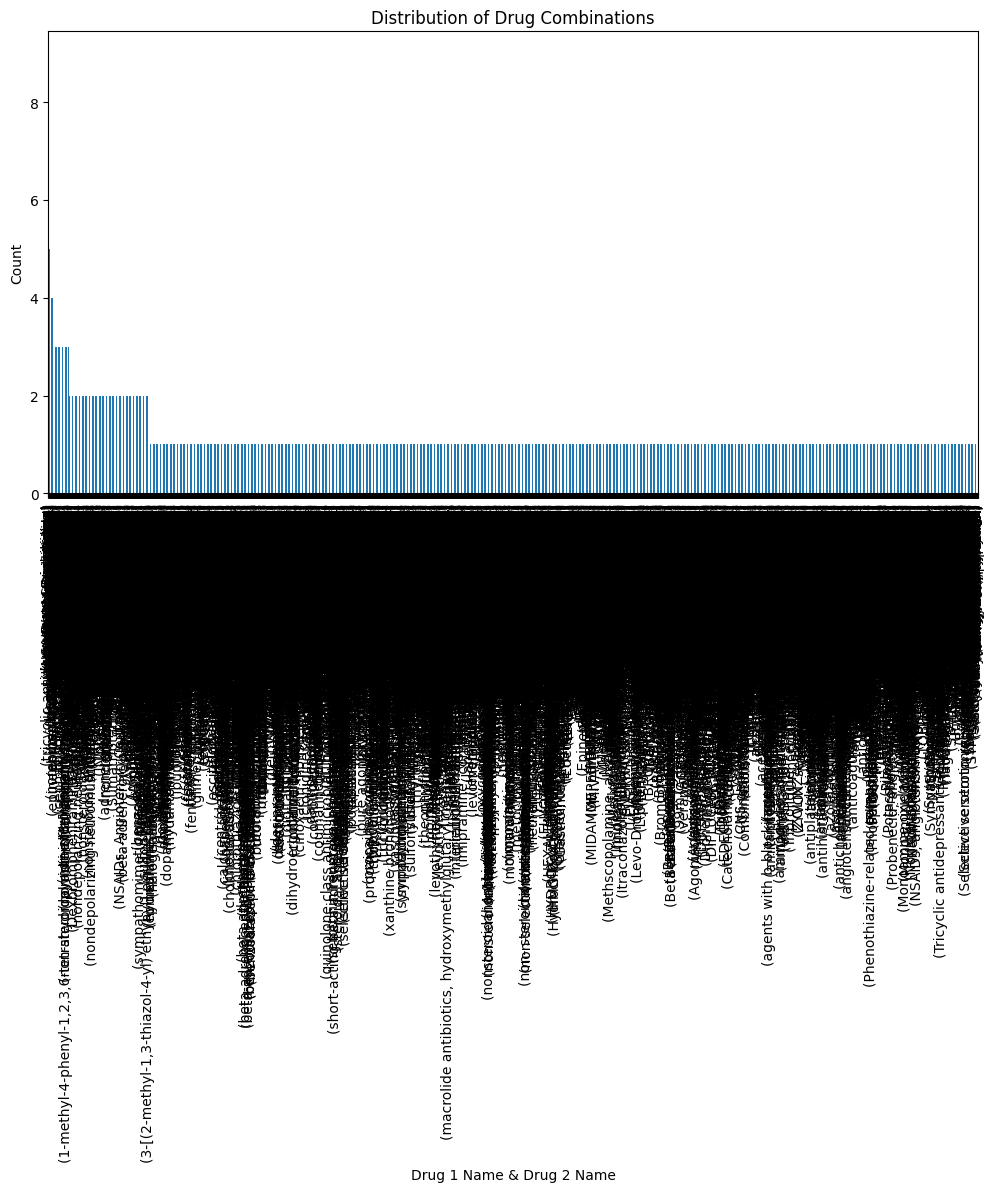

                    Drug_1_Name     Drug_2_Name  Interaction_Count
1216                     NSAIDs  ACE inhibitors                  9
4264  tricyclic antidepressants      cimetidine                  9
3304               ketoconazole       cisapride                  7
1233                     NSAIDs         lithium                  7
1230                     NSAIDs      furosemide                  6
1004                    Lithium       diuretics                  6
3946                 quinolones        caffeine                  5
3977            retinyl acetate             EGF                  5
1234                     NSAIDs    methotrexate                  5
1471                       SSRI             TCA                  5
Data cleaning, preprocessing, and EDA completed!


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = "/content/DDICorpus2013.csv"
df = pd.read_csv(file_path)
df.head()

# 1. Data Cleaning
# Check for duplicate rows
print(f"Number of duplicate rows: {df.duplicated().sum()}")
df.drop_duplicates(inplace=True)

# 2. Data Preprocessing
# No need for outlier handling, as we're interested in the interactions

# 3. Exploratory Data Analysis
# Analyze the distribution of drug combinations
plt.figure(figsize=(12, 6))
df[['Drug_1_Name', 'Drug_2_Name']].value_counts().plot(kind='bar')
plt.title('Distribution of Drug Combinations')
plt.xlabel('Drug 1 Name & Drug 2 Name')
plt.ylabel('Count')
plt.show()

# Investigate the frequency of drug interactions
interaction_counts = df.groupby(['Drug_1_Name', 'Drug_2_Name']).size().reset_index(name='Interaction_Count')
interaction_counts = interaction_counts.sort_values('Interaction_Count', ascending=False)
print(interaction_counts.head(10))

# 4. Handling Class Imbalance
# The target variable is the presence or absence of a drug interaction, so we can treat this as a binary classification problem.
# We can create a new column 'Has_Interaction' to represent this target variable.
df['Has_Interaction'] = 1
# The 'Interaction_Count' column is present in the 'interaction_counts' DataFrame, not in 'df'.
# Merge 'interaction_counts' with 'df' to bring the 'Interaction_Count' column into 'df'.
df = pd.merge(df, interaction_counts, on=['Drug_1_Name', 'Drug_2_Name'], how='left')
df['Has_Interaction'] = df['Has_Interaction'].where(df['Interaction_Count'] > 0, 0) #Now this line should work as df has the column 'Interaction_Count'

# 5. Outlier Detection and Treatment
# No need for outlier handling, as we're interested in the interactions

print('Data cleaning, preprocessing, and EDA completed!')

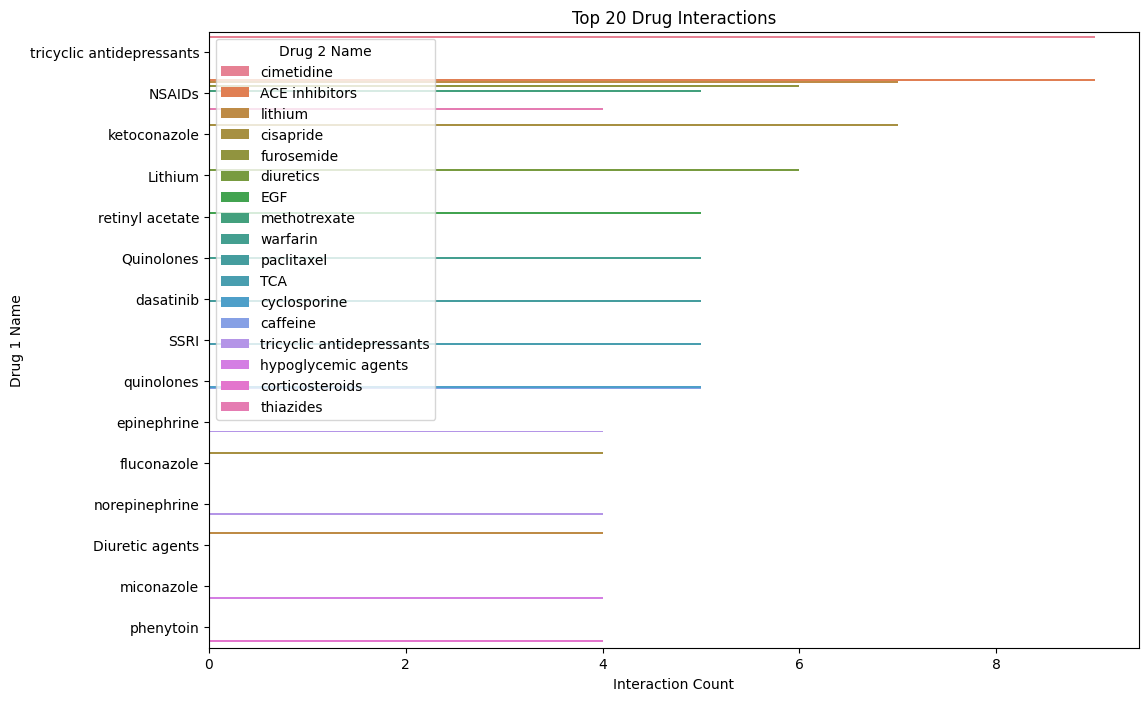

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort the interaction counts in descending order
top_interactions = interaction_counts.sort_values('Interaction_Count', ascending=False)

# Create a bar plot of the top drug interactions
plt.figure(figsize=(12, 8))
sns.barplot(x='Interaction_Count', y='Drug_1_Name', hue='Drug_2_Name', data=top_interactions.head(20))
plt.title('Top 20 Drug Interactions')
plt.xlabel('Interaction Count')
plt.ylabel('Drug 1 Name')
plt.legend(title='Drug 2 Name', loc='upper left')
plt.show()

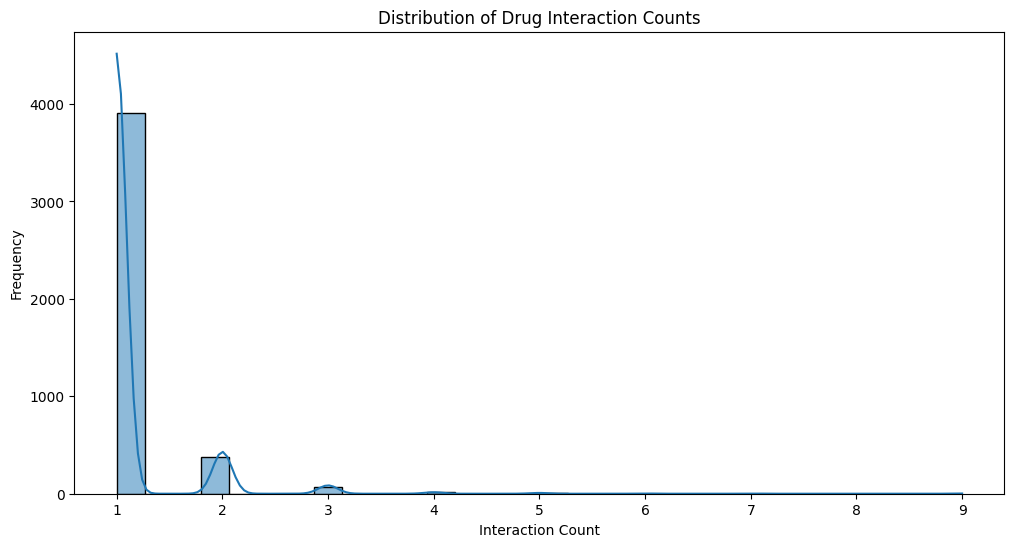

In [ ]:
# Create a histogram of the interaction counts
plt.figure(figsize=(12, 6))
sns.histplot(interaction_counts['Interaction_Count'], bins=30, kde=True)
plt.title('Distribution of Drug Interaction Counts')
plt.xlabel('Interaction Count')
plt.ylabel('Frequency')
plt.show()

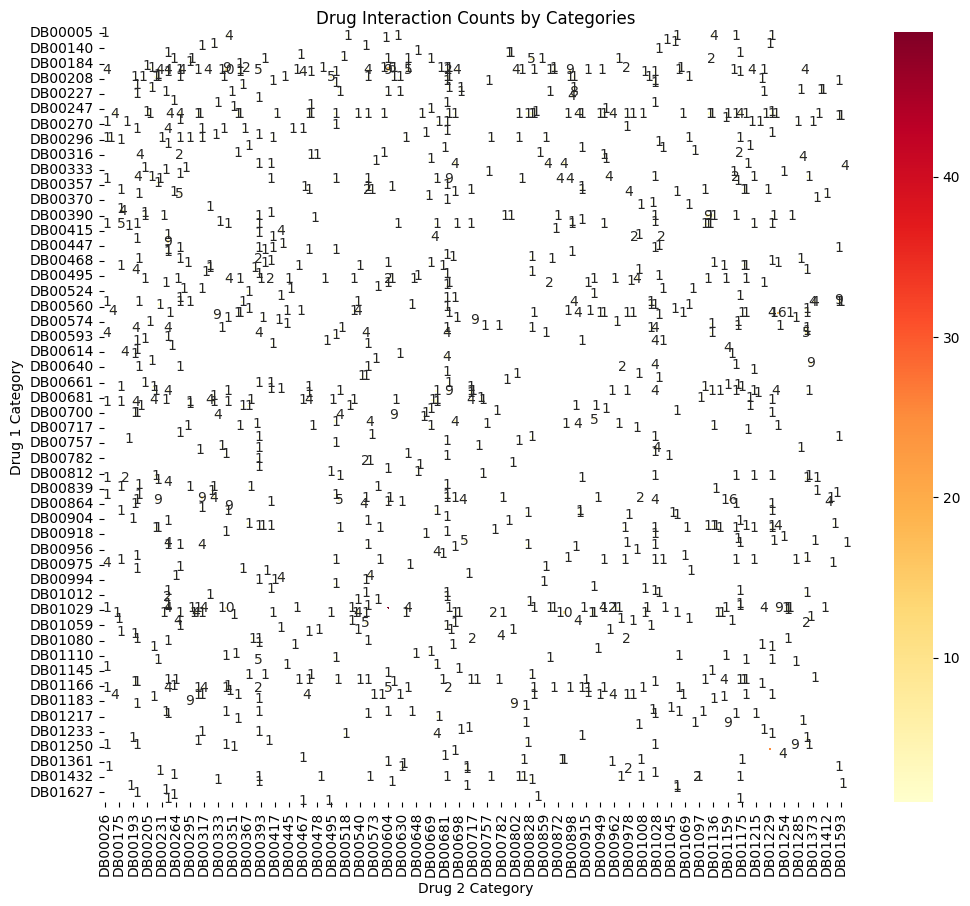

In [ ]:
# Group the data by drug categories and calculate the total interaction counts
interaction_by_category = df.groupby(['Drug_1_Drugbankid', 'Drug_2_Drugbankid'])['Interaction_Count'].sum().reset_index()
interaction_by_category = interaction_by_category.sort_values('Interaction_Count', ascending=False)

# Create a heatmap of the interaction counts by drug categories
plt.figure(figsize=(12, 10))
pivot_table = interaction_by_category.pivot(index='Drug_1_Drugbankid', columns='Drug_2_Drugbankid', values='Interaction_Count')
sns.heatmap(pivot_table, annot=True, cmap='YlOrRd')
plt.title('Drug Interaction Counts by Categories')
plt.xlabel('Drug 2 Category')
plt.ylabel('Drug 1 Category')
plt.show()

In [ ]:
!pip install --upgrade scikit-learn # Upgrade scikit-learn to the latest version

from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
# Import the dendrogram function from scipy.cluster.hierarchy
from scipy.cluster.hierarchy import dendrogram

# Perform hierarchical clustering on the interaction data
# Replace 'affinity' with 'metric'
cluster = AgglomerativeClustering(n_clusters=None, metric='euclidean', linkage='ward', distance_threshold=2.0)
cluster.fit(adjacency_matrix)

# Visualize the clusters
plt.figure(figsize=(12, 8))
# Assuming you have a dendrogram function available (e.g., from scipy.cluster.hierarchy)
# If not, you'll need to import it: from scipy.cluster.hierarchy import dendrogram
dendrogram = dendrogram(cluster.children_, truncate_mode='level', p=10)
plt.title('Dendrogram of Drug Interaction Clusters')
plt.xlabel('Drug Pairs')
plt.ylabel('Distance')
plt.show()

TypeError: Linkage matrix 'Z' must contain doubles.

<Figure size 1200x800 with 0 Axes>

Class weights: {'frequent': 12.445273631840797, 'moderate': 1.7263630089717046, 'rare': 0.42727816209753183}

Before weighting:
interaction_category
rare        3903
moderate     966
frequent     134
Name: count, dtype: int64

After weighting (normalized):
frequent    0.333333
moderate    0.333333
rare        0.333333
dtype: float64


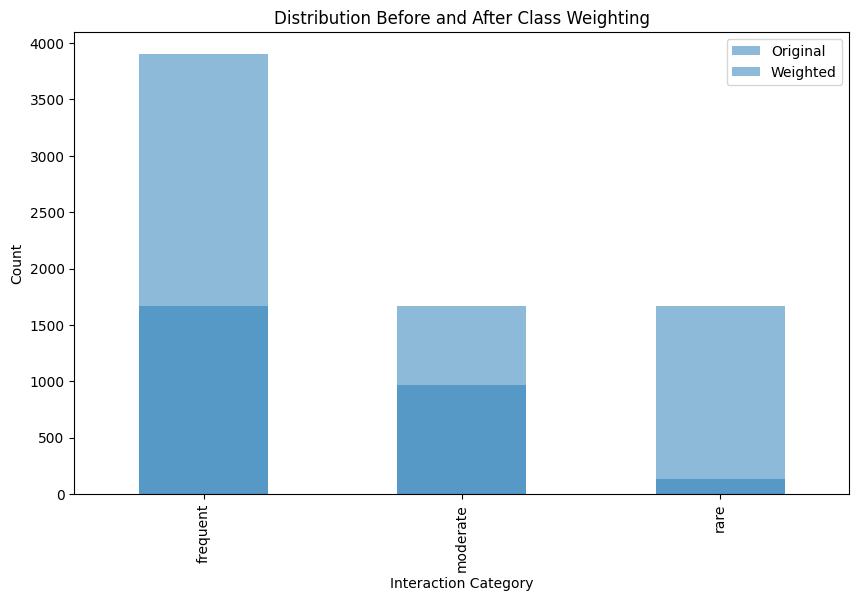

In [ ]:
import pandas as pd
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Assuming we have our dataframe 'df' with interaction counts
# First, let's create a simplified target variable based on interaction frequency
def categorize_interaction(count):
    if count == 1:
        return 'rare'
    elif count <= 3:
        return 'moderate'
    else:
        return 'frequent'

# Add interaction category column
df['interaction_category'] = df['Interaction_Count'].apply(categorize_interaction)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df['interaction_category']),
    y=df['interaction_category']
)

# Create a dictionary of class weights
weight_dict = dict(zip(np.unique(df['interaction_category']), class_weights))

print("Class weights:", weight_dict)

# Now let's see the distribution before and after applying weights
print("\nBefore weighting:")
print(df['interaction_category'].value_counts())

print("\nAfter weighting (normalized):")
weighted_counts = df['interaction_category'].value_counts() * pd.Series(weight_dict)
print(weighted_counts / weighted_counts.sum())

# Visualize the effect of weighting
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
df['interaction_category'].value_counts().plot(kind='bar', alpha=0.5, label='Original')
(df['interaction_category'].value_counts() * pd.Series(weight_dict)).plot(kind='bar', alpha=0.5, label='Weighted')
plt.title('Distribution Before and After Class Weighting')
plt.xlabel('Interaction Category')
plt.ylabel('Count')
plt.legend()
plt.show()

<ipython-input-2-20015d0d988a>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Drug_1_Name'] = df['Drug_1_Name'].fillna('Unknown')
<ipython-input-2-20015d0d988a>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Drug_2_Name'] = df['Drug_2_Name'].fillna('Unknown')
<ipython-input-2-20015d0d988a>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p


Data Quality Report:
original_rows: 5032
cleaned_rows: 5003
duplicates_removed: 29
missing_values: {'DDI_ID': 1, 'Drug_1_Name': 3, 'Drug_1_Drugbankid': 2501, 'ent_type': 3, 'Drug_2_Name': 3, 'Drug_2_Drugbankid': 2436, 'Is_DDI': 3, 'DDI_Type': 4, 'ent_type.1': 3, 'Sentence_Text': 3}
unique_drug1: 1144
unique_drug2: 1275
total_interactions: 5003


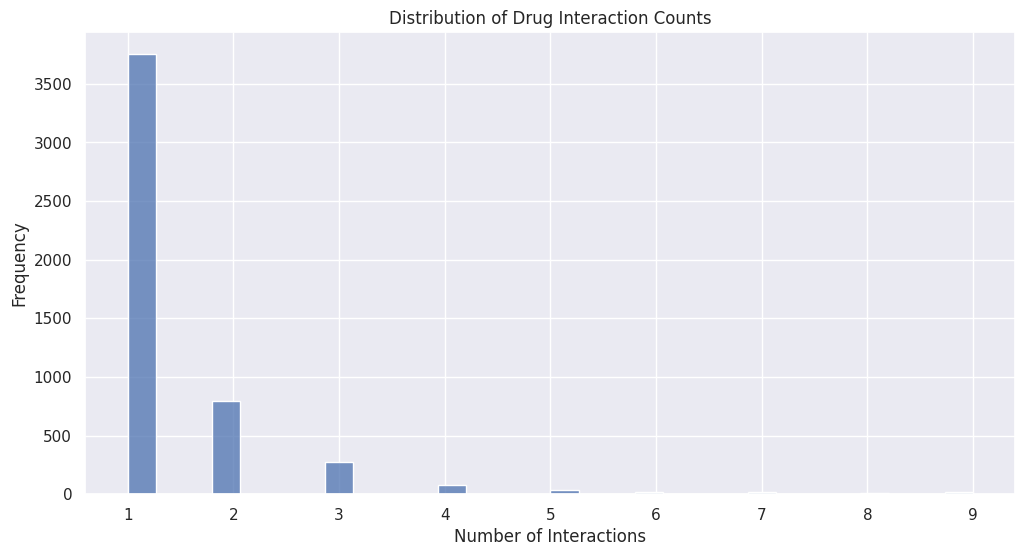

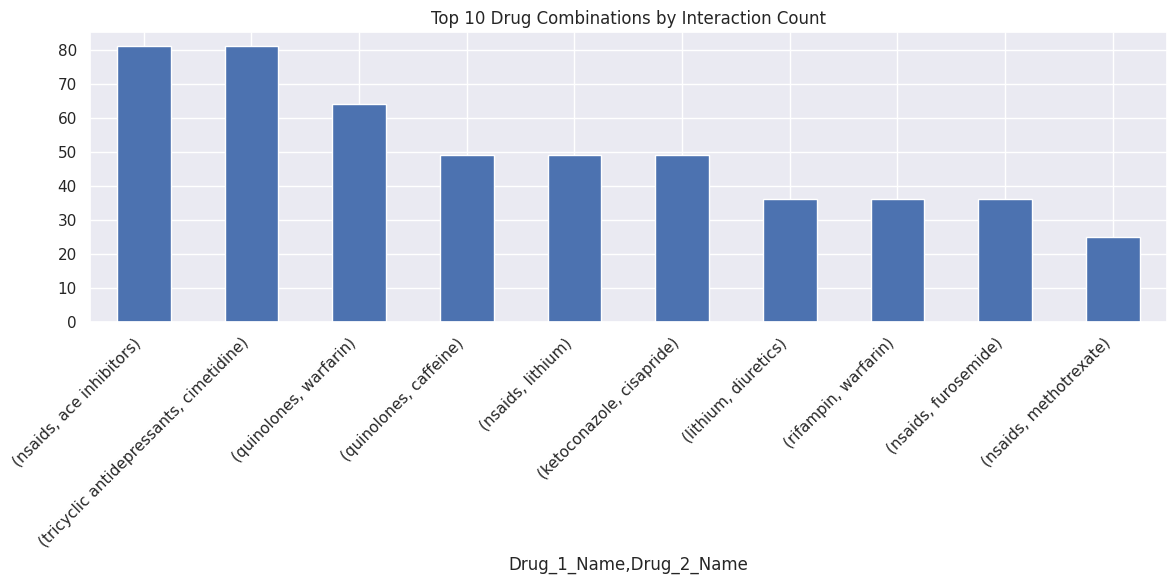

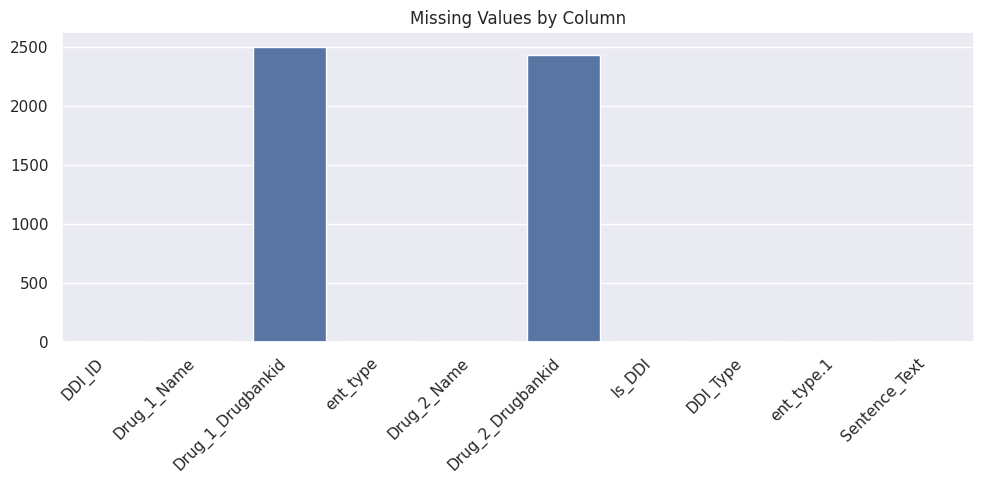

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def clean_drug_interaction_data(df):
    """
    Comprehensive data cleaning pipeline for drug interaction dataset.

    Parameters:
    df (pandas.DataFrame): Input DataFrame with drug interaction data

    Returns:
    pandas.DataFrame: Cleaned DataFrame
    dict: Data quality report
    """
    # Store original shape
    original_shape = df.shape

    # 1. Basic Data Cleaning
    # Remove duplicates
    df = df.drop_duplicates()

    # 2. Handle Missing Values
    missing_report = df.isnull().sum()

    # Fill missing values appropriately
    df['Drug_1_Name'] = df['Drug_1_Name'].fillna('Unknown')
    df['Drug_2_Name'] = df['Drug_2_Name'].fillna('Unknown')

    # 3. Text Cleaning for Drug Names
    # Convert to lowercase and strip whitespace
    df['Drug_1_Name'] = df['Drug_1_Name'].str.lower().str.strip()
    df['Drug_2_Name'] = df['Drug_2_Name'].str.lower().str.strip()

    # Remove special characters
    df['Drug_1_Name'] = df['Drug_1_Name'].str.replace('[^\w\s]', '', regex=True)
    df['Drug_2_Name'] = df['Drug_2_Name'].str.replace('[^\w\s]', '', regex=True)

    # 4. Feature Engineering
    # Create interaction frequency features
    interaction_counts = df.groupby(['Drug_1_Name', 'Drug_2_Name']).size().reset_index(name='Interaction_Count')
    df = pd.merge(df, interaction_counts, on=['Drug_1_Name', 'Drug_2_Name'], how='left')

    # Create binary interaction indicator
    df['Has_Interaction'] = 1
    df['Has_Interaction'] = df['Has_Interaction'].where(df['Interaction_Count'] > 0, 0)

    # 5. Data Validation
    # Ensure no negative counts
    df['Interaction_Count'] = df['Interaction_Count'].clip(lower=0)

    # 6. Generate Data Quality Report
    quality_report = {
        'original_rows': original_shape[0],
        'cleaned_rows': df.shape[0],
        'duplicates_removed': original_shape[0] - df.shape[0],
        'missing_values': missing_report.to_dict(),
        'unique_drug1': df['Drug_1_Name'].nunique(),
        'unique_drug2': df['Drug_2_Name'].nunique(),
        'total_interactions': df['Has_Interaction'].sum()
    }

    return df, quality_report

def visualize_data_quality(df, quality_report):
    """
    Create visualizations for data quality assessment.

    Parameters:
    df (pandas.DataFrame): Cleaned DataFrame
    quality_report (dict): Data quality report from cleaning function
    """
    # Set up the plotting style using Seaborn
    # plt.style.use('seaborn') # This line caused the error because 'seaborn' is not a built-in Matplotlib style
    sns.set() # This line sets the default Seaborn style, which uses Matplotlib under the hood

    # 1. Drug Interaction Distribution
    plt.figure(figsize=(12, 6))
    sns.histplot(data=df, x='Interaction_Count', bins=30)
    plt.title('Distribution of Drug Interaction Counts')
    plt.xlabel('Number of Interactions')
    plt.ylabel('Frequency')
    plt.show()

    # 2. Top Drug Combinations
    plt.figure(figsize=(12, 6))
    top_combinations = df.groupby(['Drug_1_Name', 'Drug_2_Name'])['Interaction_Count'].sum().sort_values(ascending=False).head(10)
    top_combinations.plot(kind='bar')
    plt.title('Top 10 Drug Combinations by Interaction Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # 3. Missing Value Summary
    if any(quality_report['missing_values'].values()):
        plt.figure(figsize=(10, 5))
        sns.barplot(x=list(quality_report['missing_values'].keys()),
                   y=list(quality_report['missing_values'].values()))
        plt.title('Missing Values by Column')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

# Example usage
if __name__ == "__main__":
    # Load the dataset
    file_path = "/content/DDICorpus2013.csv"
    df = pd.read_csv(file_path)

    # Clean the data
    cleaned_df, quality_report = clean_drug_interaction_data(df)

    # Print the quality report
    print("\nData Quality Report:")
    for key, value in quality_report.items():
        print(f"{key}: {value}")

    # Visualize the data quality
    visualize_data_quality(cleaned_df, quality_report)

<ipython-input-3-46327f612e30>:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


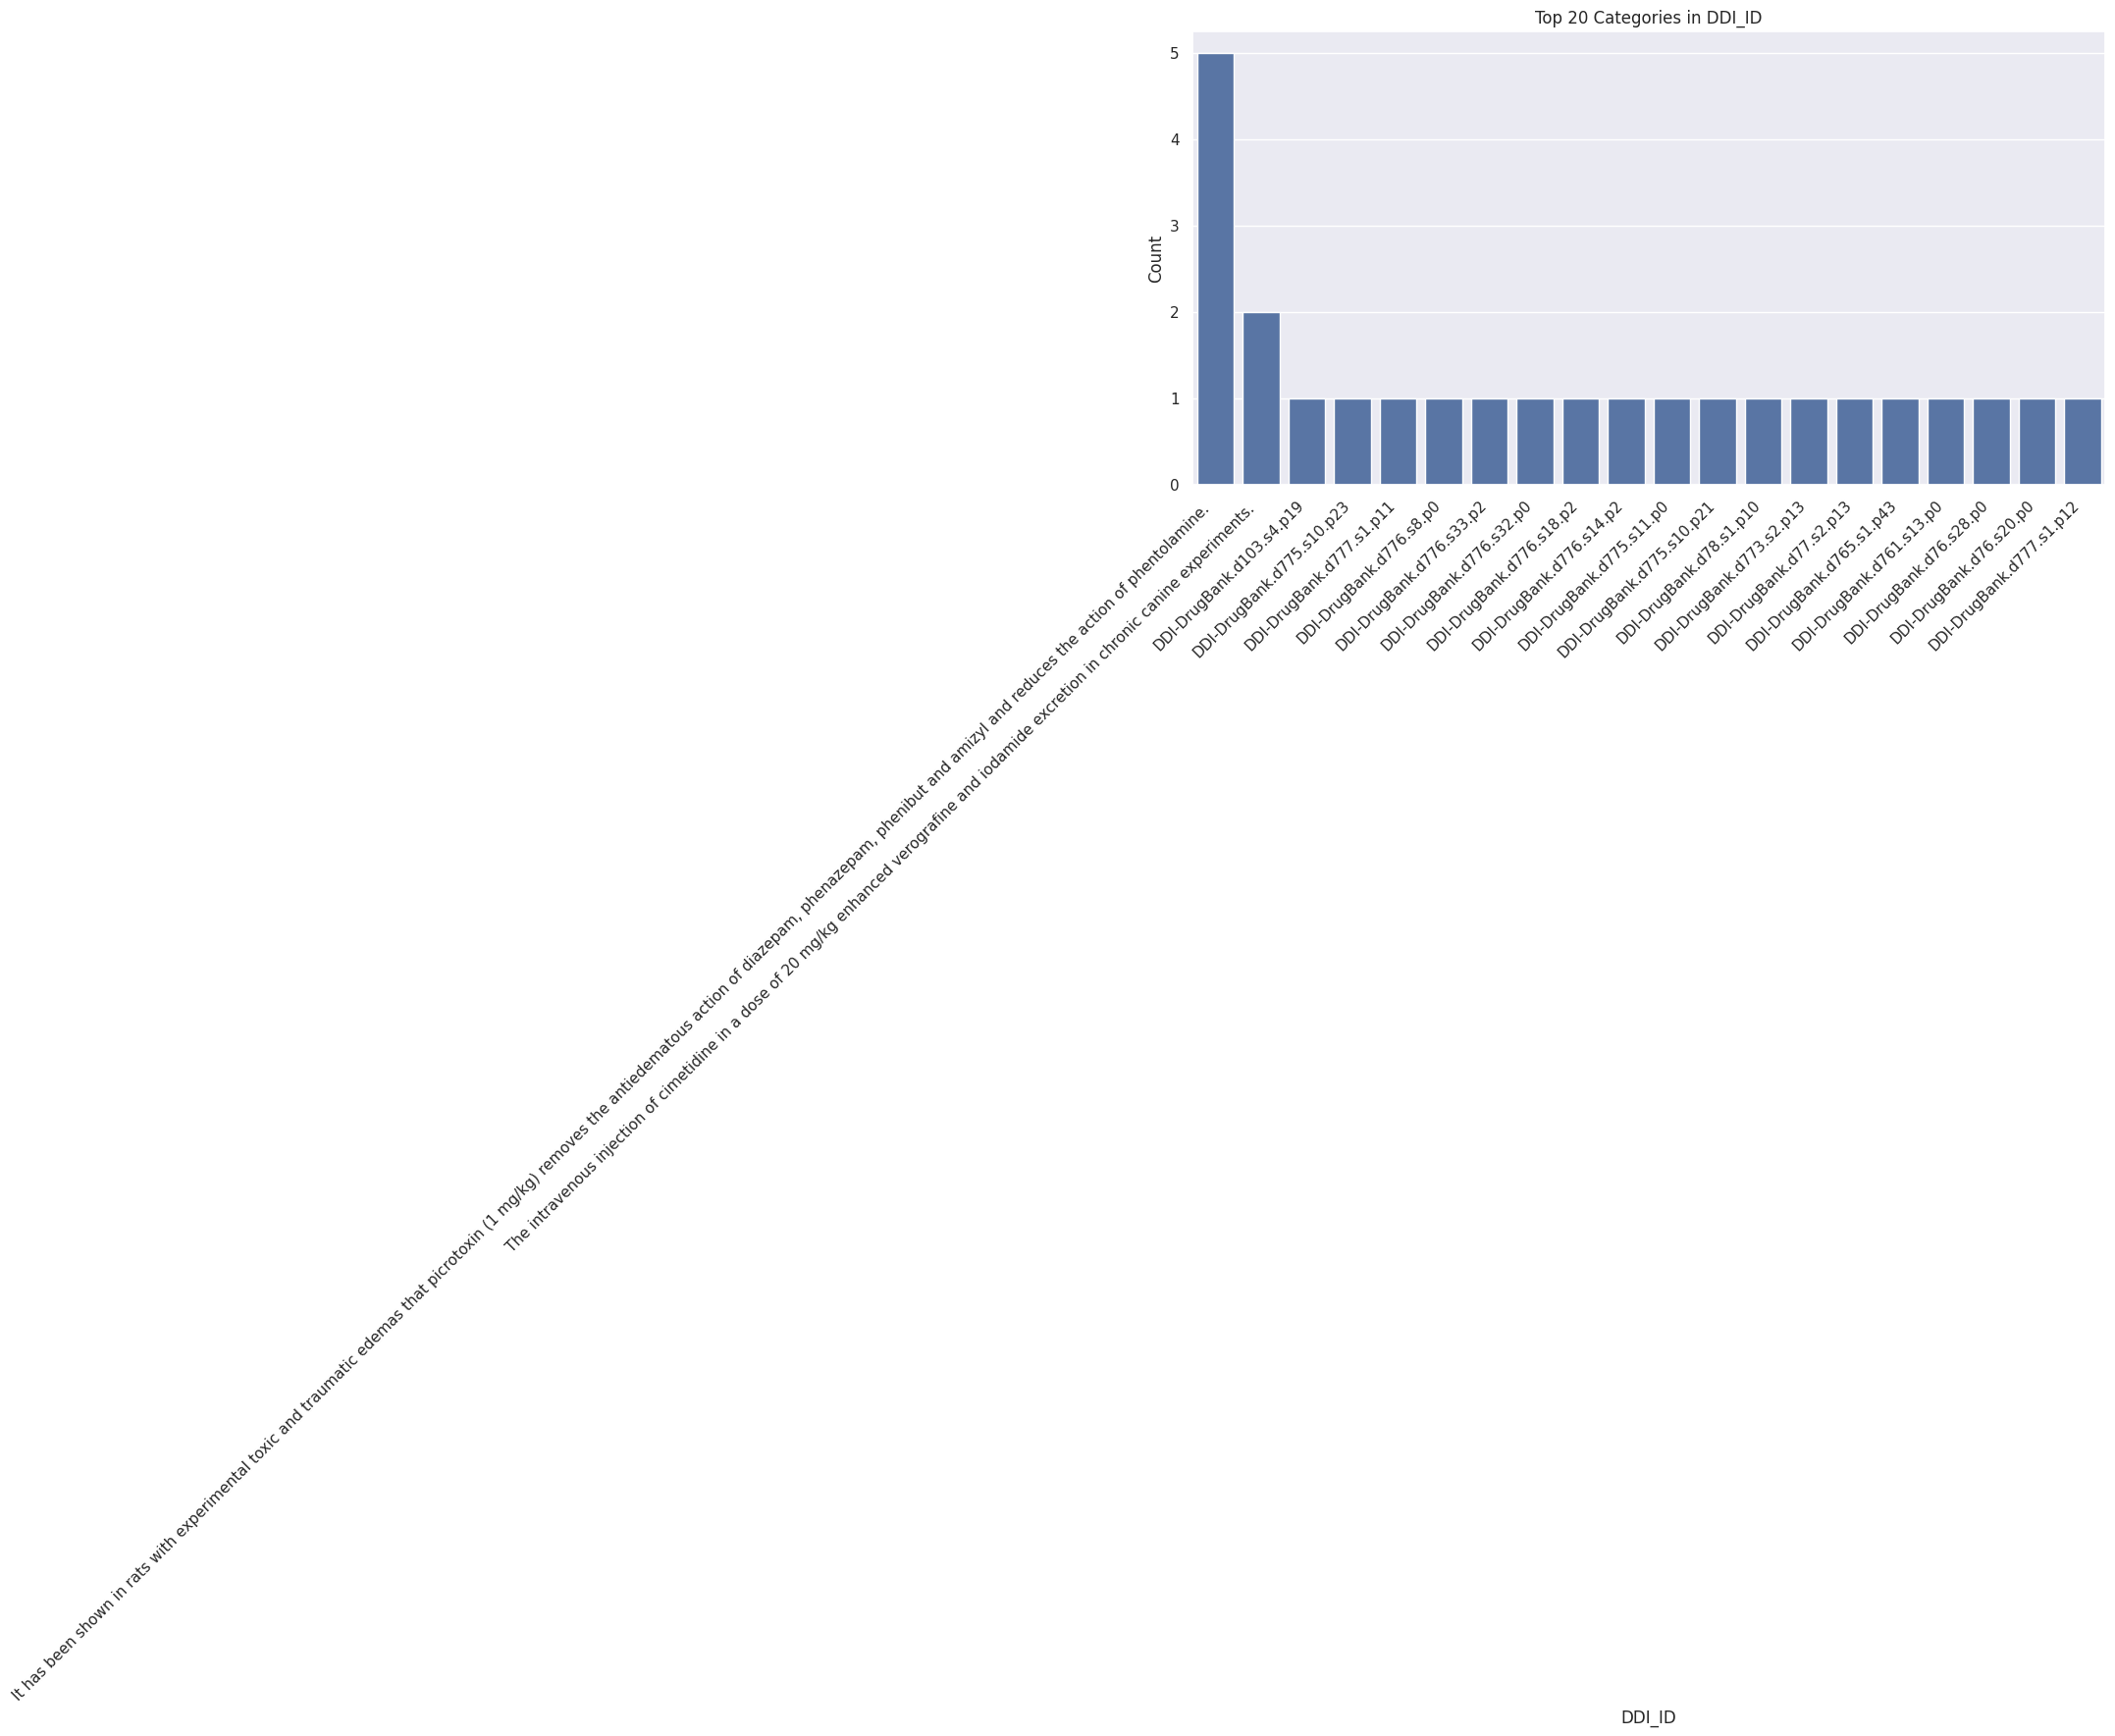

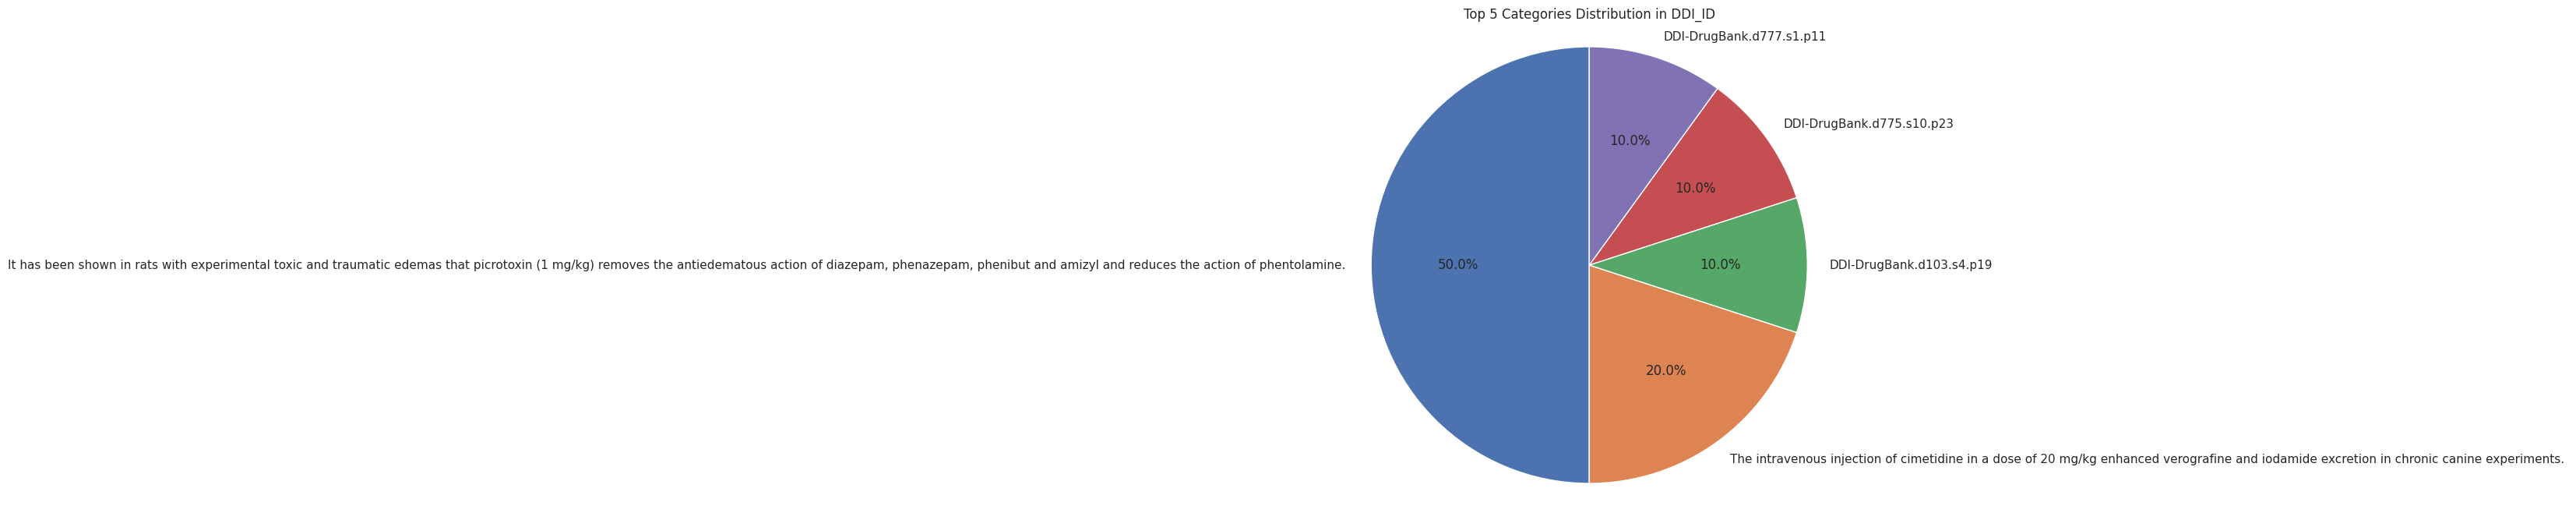

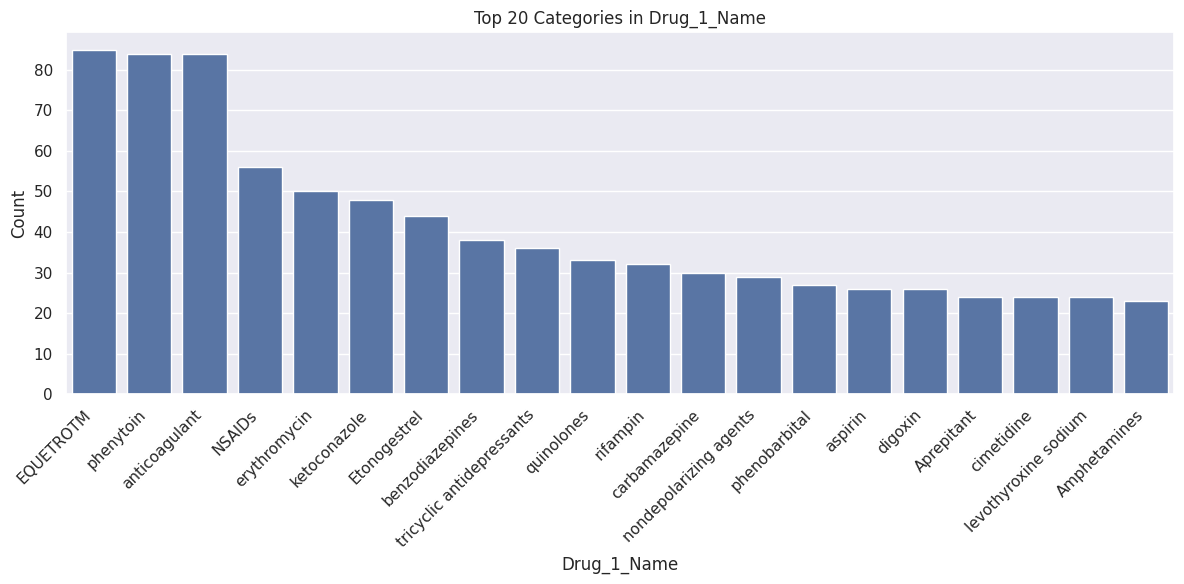

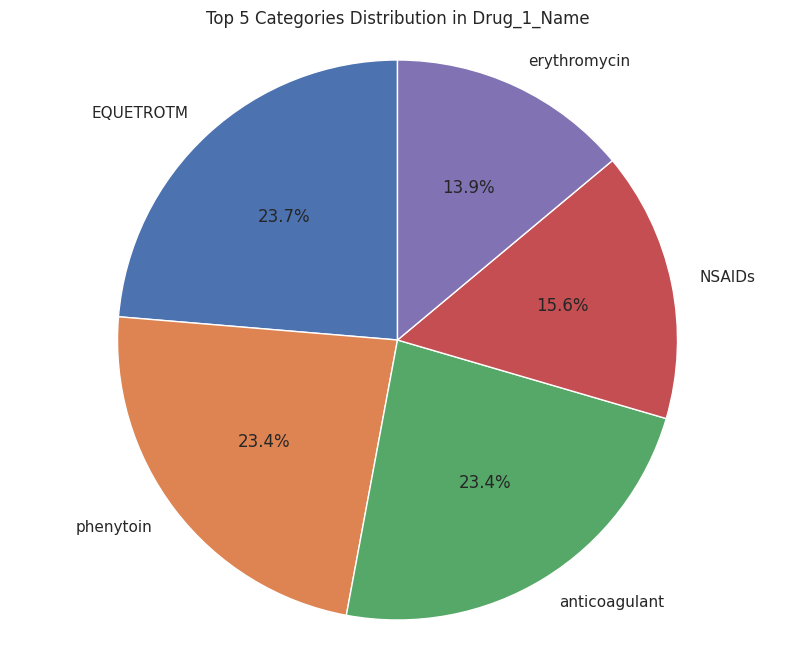

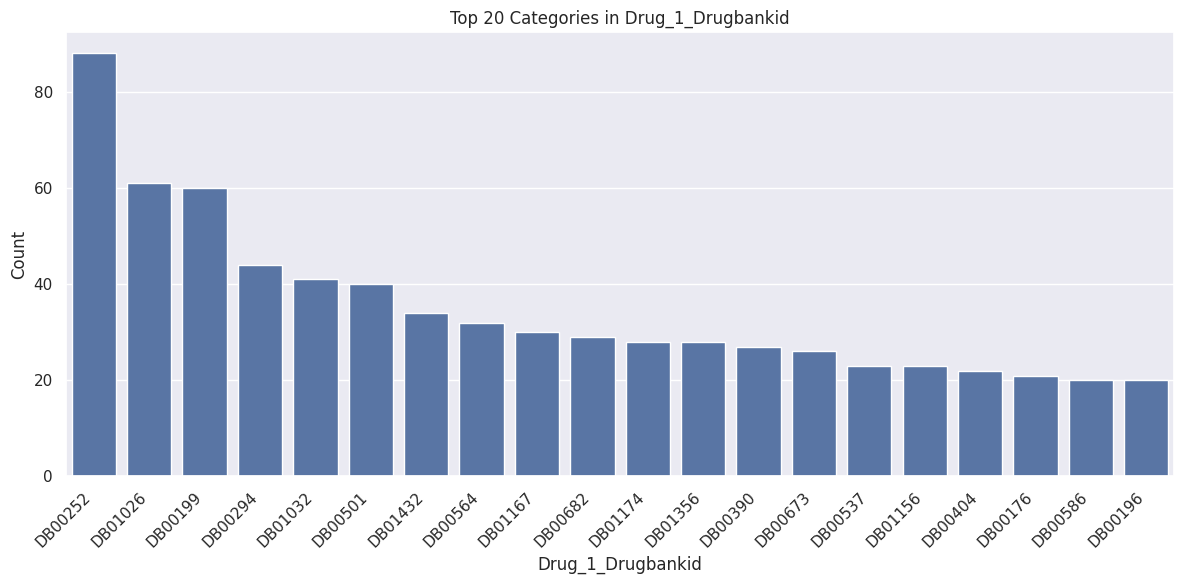

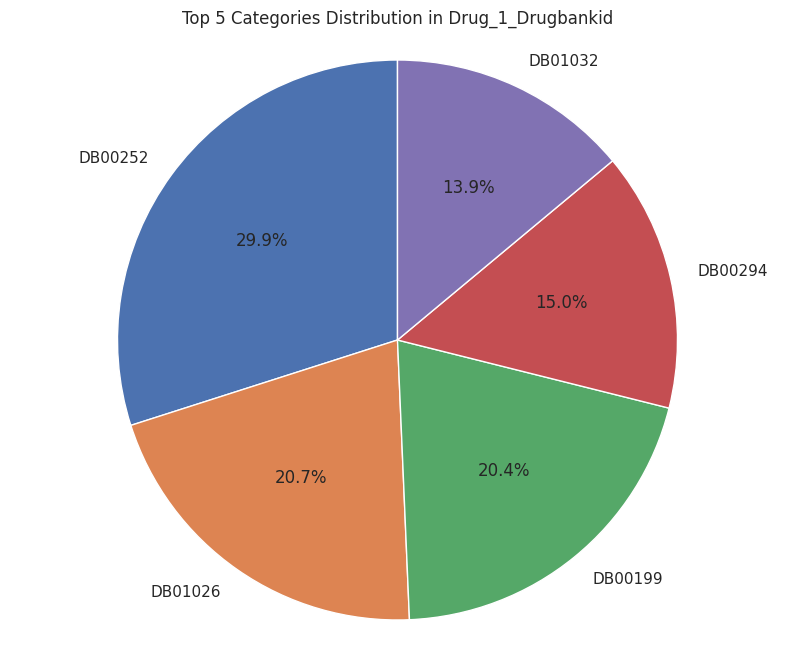

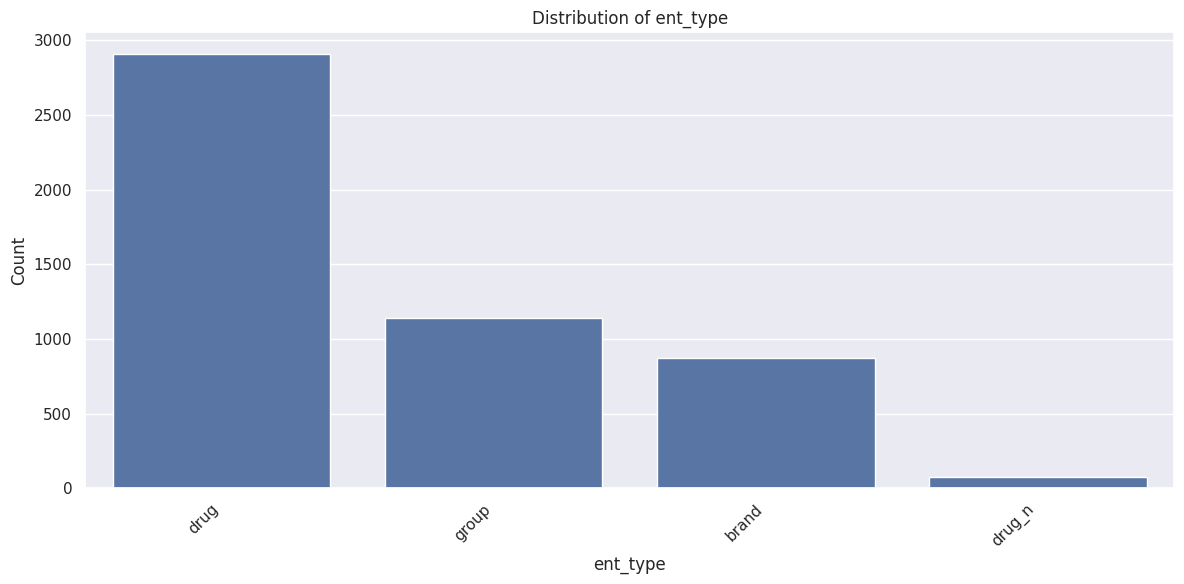

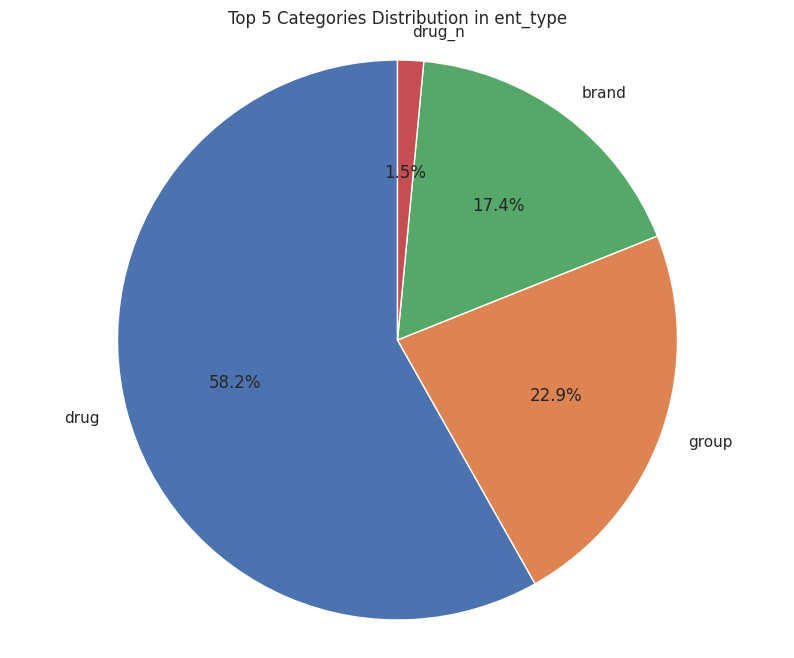

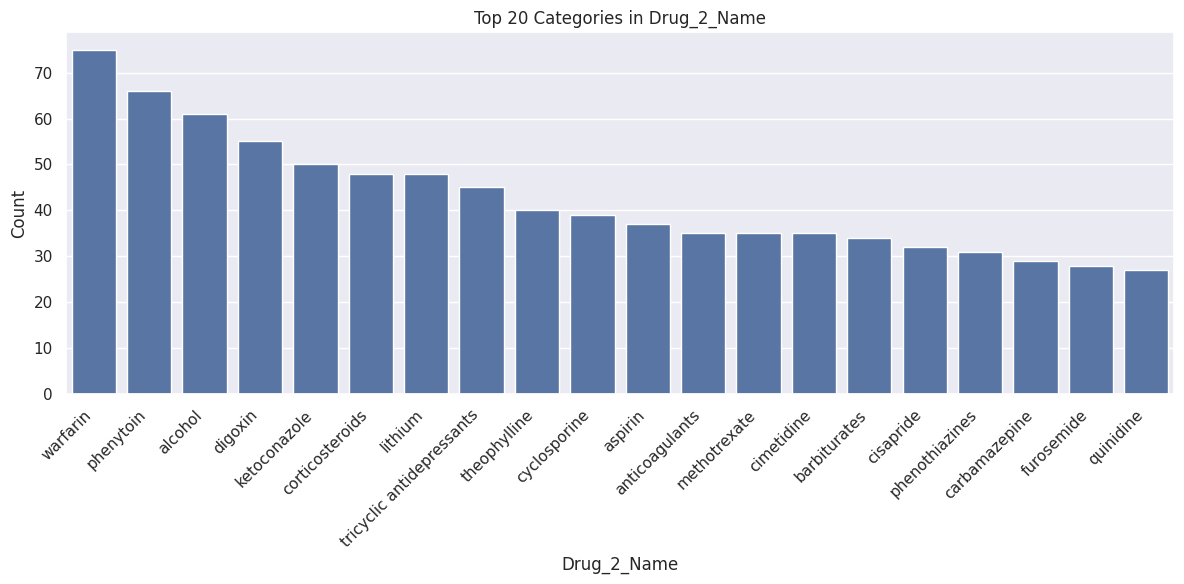

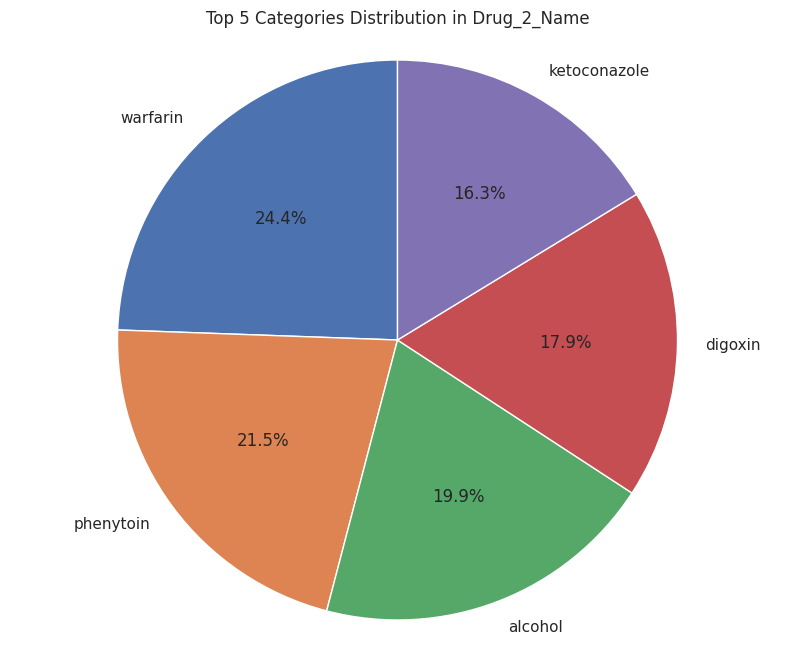

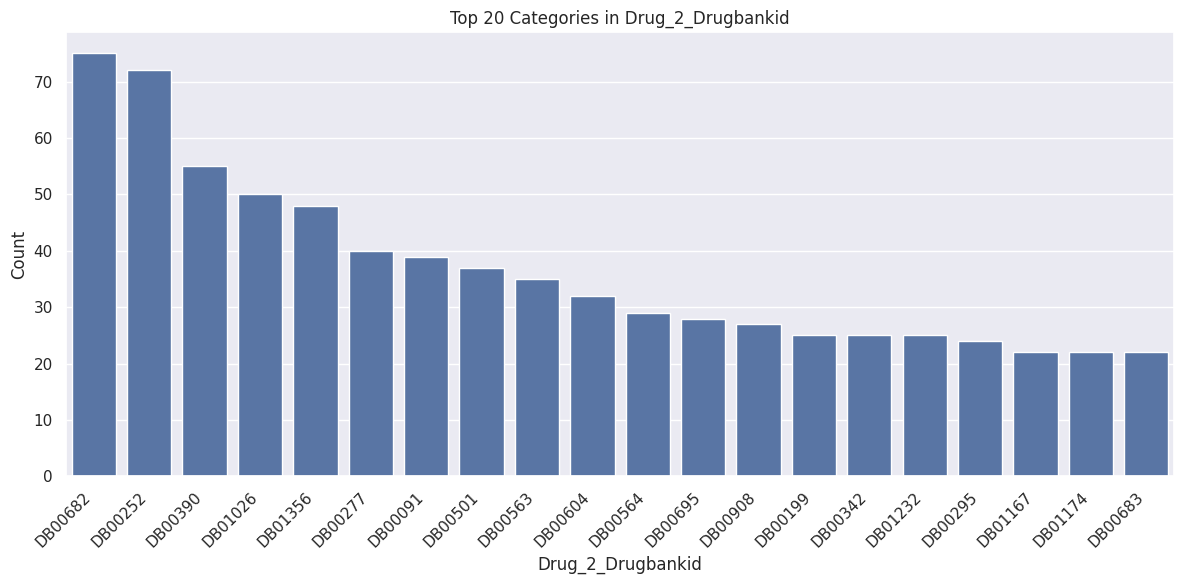

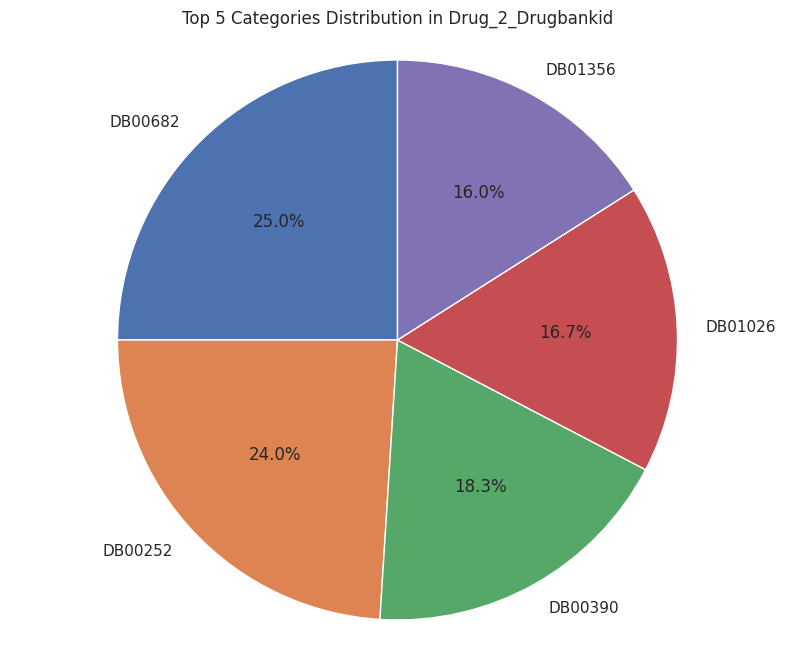

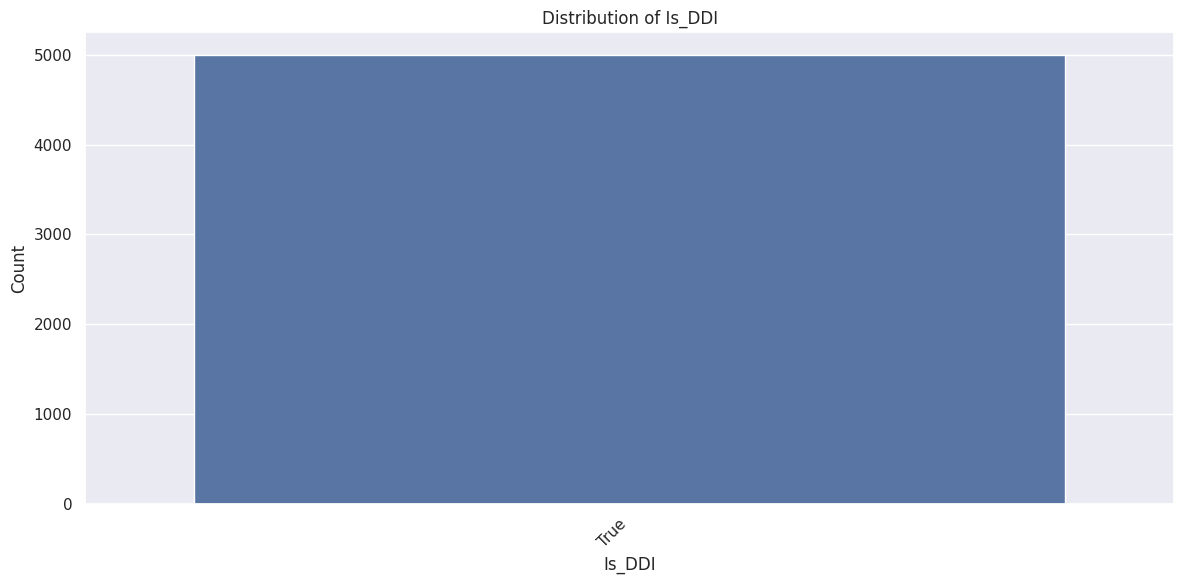

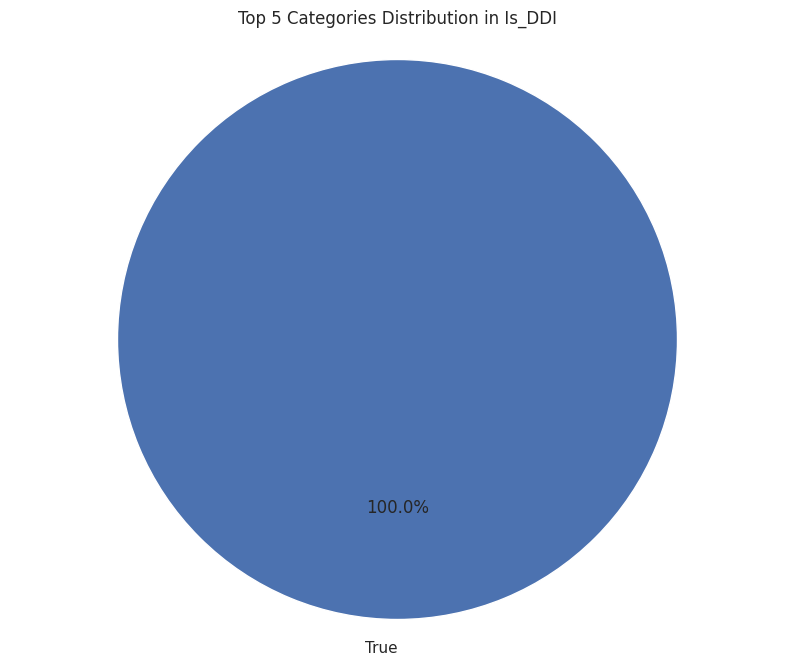

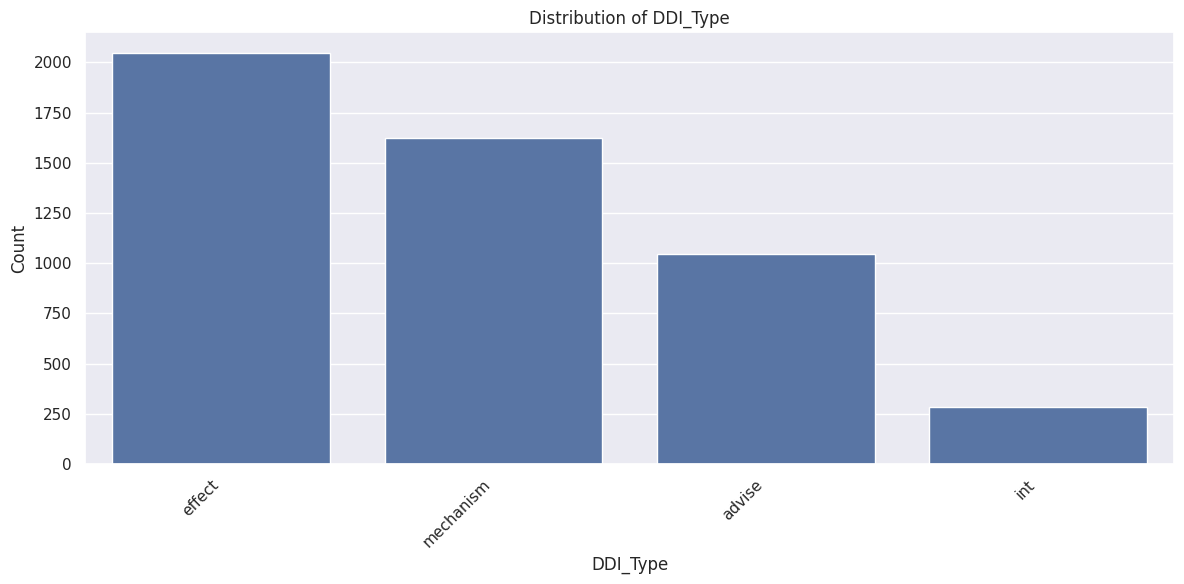

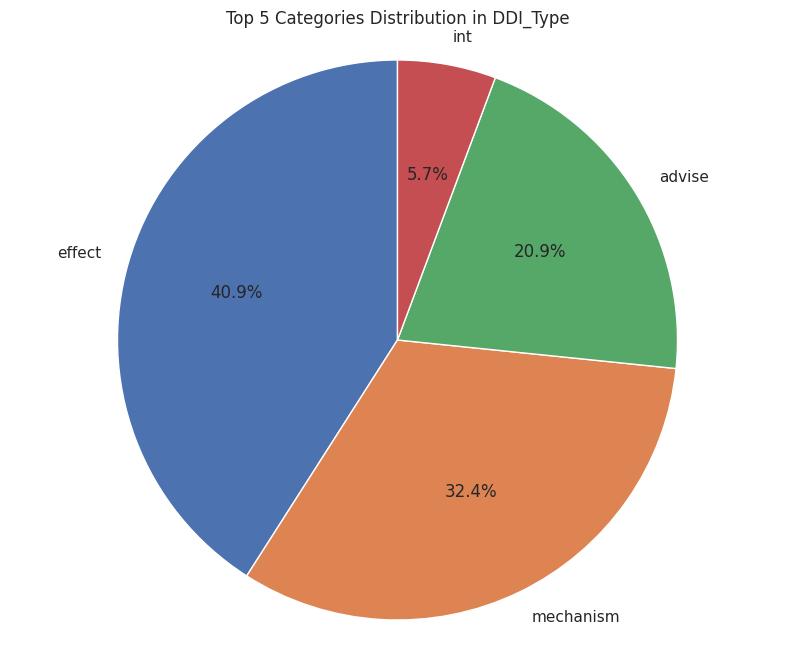

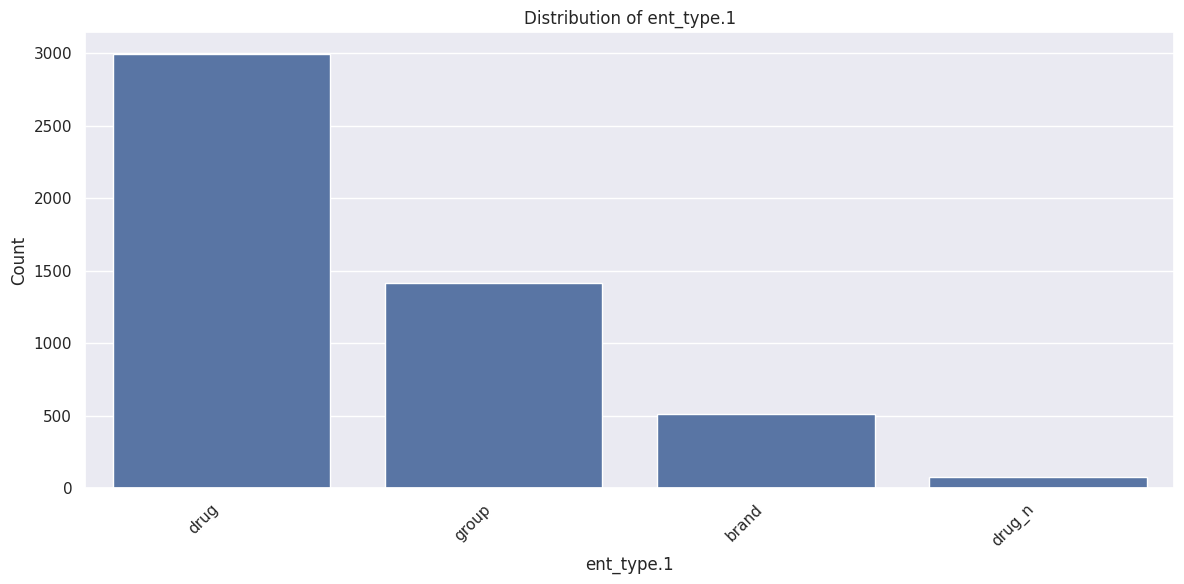

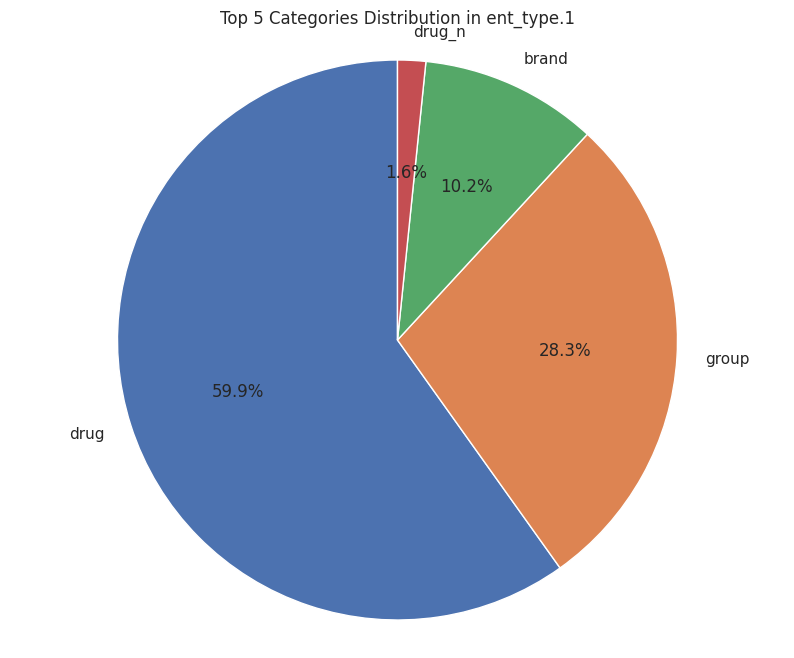

<ipython-input-3-46327f612e30>:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


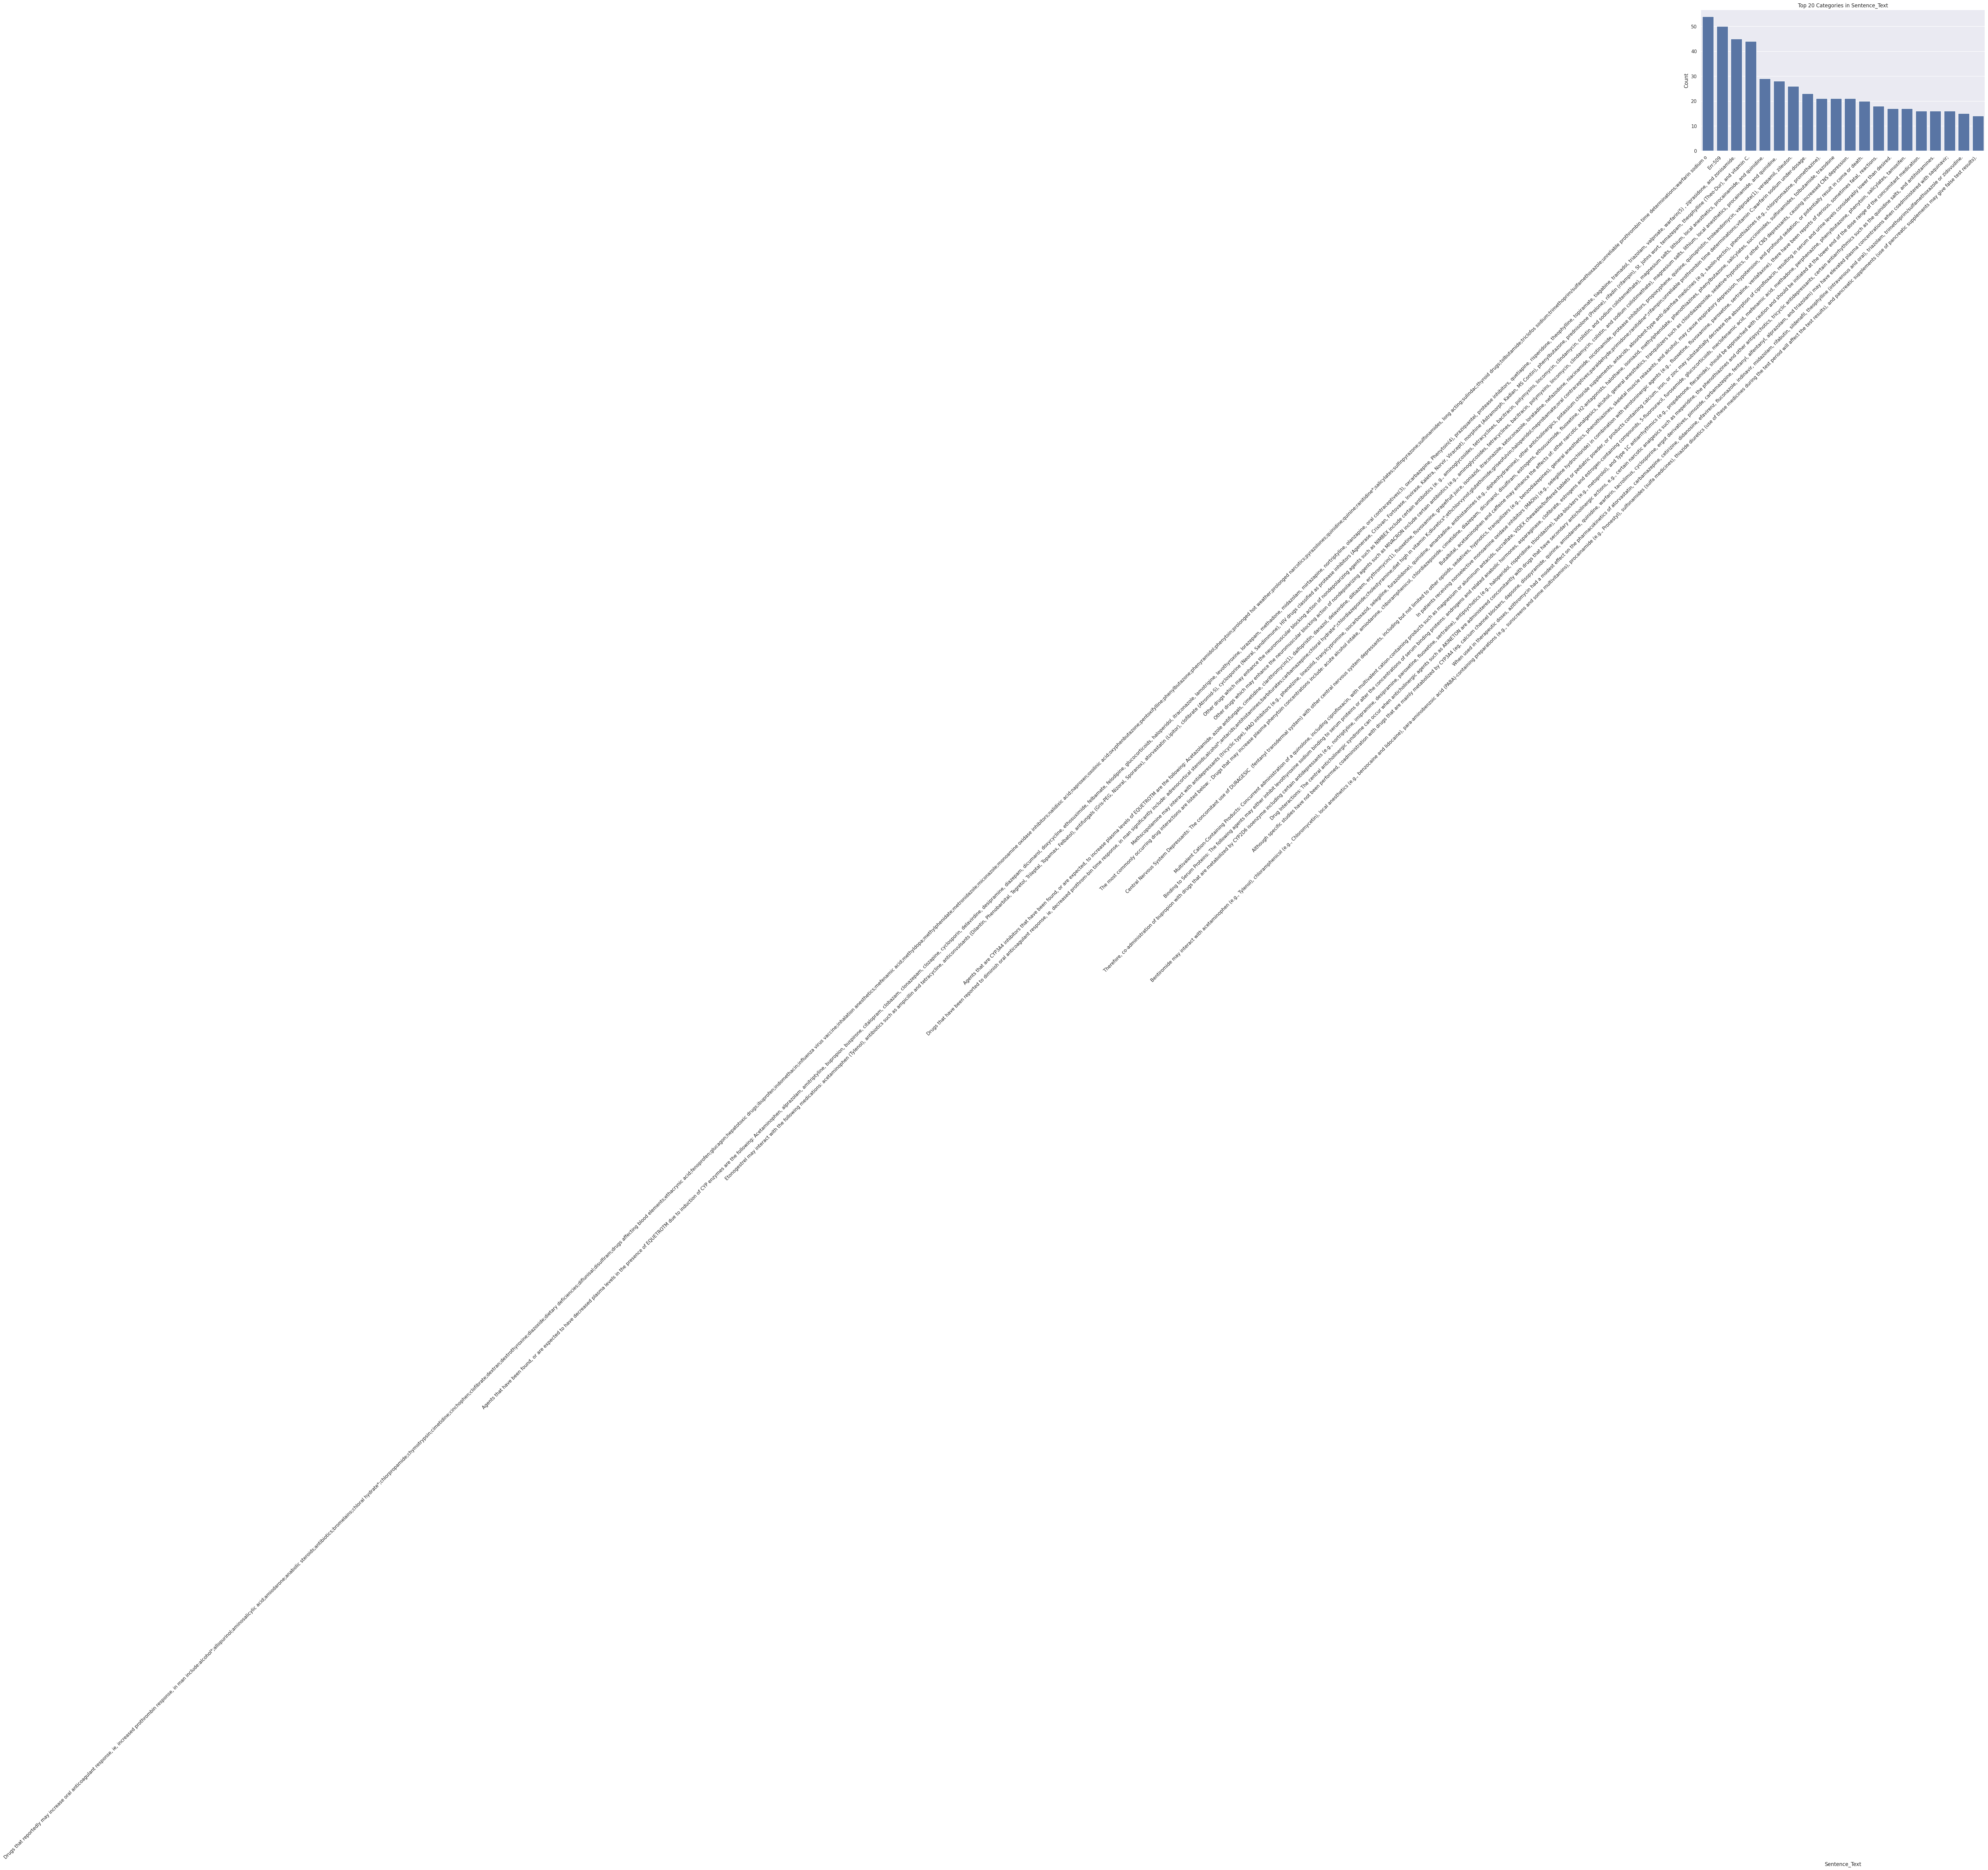

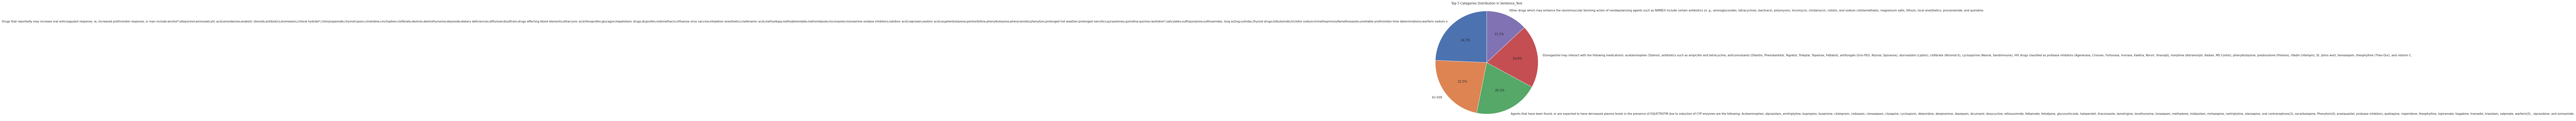


Column: DDI_ID
Number of unique values: 5002
Missing values: 25 (0.50%)

Top 5 most common values:
  It has been shown in rats with experimental toxic and traumatic edemas that picrotoxin (1 mg/kg) removes the antiedematous action of diazepam, phenazepam, phenibut and amizyl and reduces the action of phentolamine. : 5 (0.10%)
  The intravenous injection of cimetidine in a dose of 20 mg/kg enhanced verografine and iodamide excretion in chronic canine experiments. : 2 (0.04%)
  DDI-DrugBank.d103.s4.p19: 1 (0.02%)
  DDI-DrugBank.d775.s10.p23: 1 (0.02%)
  DDI-DrugBank.d777.s1.p11: 1 (0.02%)

Column: Drug_1_Name
Number of unique values: 1335
Missing values: 32 (0.64%)

Top 5 most common values:
  EQUETROTM: 85 (1.70%)
  phenytoin: 84 (1.68%)
  anticoagulant: 84 (1.68%)
  NSAIDs: 56 (1.12%)
  erythromycin: 50 (1.00%)

Column: Drug_1_Drugbankid
Number of unique values: 475
Missing values: 2530 (50.28%)

Top 5 most common values:
  DB00252: 88 (3.52%)
  DB01026: 61 (2.44%)
  DB00199: 60 (2.40

NameError: name 'chi2_contingency' is not defined

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

negative_samples_improved = 1
def analyze_categorical_variables(df, max_categories=20):
    """
    Analyze categorical variables in the dataset.

    Parameters:
    df (pandas.DataFrame): Input DataFrame
    max_categories (int): Maximum number of categories to display in plots

    Returns:
    dict: Summary statistics for categorical variables
    """
    # Identify categorical columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns

    # Initialize summary dictionary
    summary = {}

    # Create subplots for each categorical variable
    for col in categorical_cols:
        # Calculate value counts and percentages
        value_counts = df[col].value_counts()
        value_percentages = df[col].value_counts(normalize=True) * 100

        # Store summary statistics
        summary[col] = {
            'unique_values': df[col].nunique(),
            'missing_values': df[col].isnull().sum(),
            'missing_percentage': (df[col].isnull().sum() / len(df)) * 100,
            'most_common': value_counts.head(5).to_dict(),
            'value_percentages': value_percentages.head(5).to_dict()
        }

        # Create visualization
        plt.figure(figsize=(12, 6))

        # If too many categories, show only top ones
        if len(value_counts) > max_categories:
            value_counts = value_counts.head(max_categories)
            plt.title(f'Top {max_categories} Categories in {col}')
        else:
            plt.title(f'Distribution of {col}')

        sns.barplot(x=value_counts.index, y=value_counts.values)
        plt.xticks(rotation=45, ha='right')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.tight_layout()
        plt.show()

        # Create pie chart for top 5 categories
        plt.figure(figsize=(10, 8))
        plt.pie(value_percentages.head(5), labels=value_percentages.head(5).index,
                autopct='%1.1f%%', startangle=90)
        plt.title(f'Top 5 Categories Distribution in {col}')
        plt.axis('equal')
        plt.show()

    return summary

def create_correlation_heatmap(df):
    """
    Create a correlation heatmap for categorical variables using Cramer's V.

    Parameters:
    df (pandas.DataFrame): Input DataFrame
    """
    def cramers_v(x, y):
        confusion_matrix = pd.crosstab(x, y)
        chi2 = chi2_contingency(confusion_matrix)[0]
        n = confusion_matrix.sum().sum()
        min_dim = min(confusion_matrix.shape) - 1
        return np.sqrt(chi2 / (n * min_dim))

    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    n_cols = len(categorical_cols)

    # Create correlation matrix
    corr_matrix = np.zeros((n_cols, n_cols))

    for i, col1 in enumerate(categorical_cols):
        for j, col2 in enumerate(categorical_cols):
            if i != j:
                corr_matrix[i, j] = cramers_v(df[col1], df[col2])
            else:
                corr_matrix[i, j] = 1.0

    # Create heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(pd.DataFrame(corr_matrix,
                            index=categorical_cols,
                            columns=categorical_cols),
                annot=True, cmap='coolwarm', vmin=0, vmax=1)
    plt.title('Categorical Variables Correlation (Cramer\'s V)')
    plt.tight_layout()
    plt.show()

def print_categorical_summary(summary):
    """
    Print a formatted summary of categorical variables.

    Parameters:
    summary (dict): Summary dictionary from analyze_categorical_variables
    """
    for col, stats in summary.items():
        print(f"\n{'='*50}")
        print(f"Column: {col}")
        print(f"{'='*50}")
        print(f"Number of unique values: {stats['unique_values']}")
        print(f"Missing values: {stats['missing_values']} ({stats['missing_percentage']:.2f}%)")

        print("\nTop 5 most common values:")
        for value, count in stats['most_common'].items():
            percentage = stats['value_percentages'][value]
            print(f"  {value}: {count} ({percentage:.2f}%)")

# Example usage
def main():
    # Load your dataset
    file_path = "/content/DDICorpus2013.csv"
    df = pd.read_csv(file_path)

    # Analyze categorical variables
    summary = analyze_categorical_variables(df)

    # Print summary
    print_categorical_summary(summary)

    # Create correlation heatmap
    create_correlation_heatmap(df)

if __name__ == "__main__":
    main()

Model Selection and Implementation

In [ ]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
!pip install ace_tools
# Step 1: Handle Missing Values (Remove rows with missing drug names or interaction sentences)
df_preprocessed = df.dropna(subset=["Drug_1_Name", "Drug_2_Name", "Sentence_Text"])

# Step 2: Normalize Drug Names (Lowercase, strip spaces)
df_preprocessed["Drug_1_Name"] = df_preprocessed["Drug_1_Name"].str.lower().str.strip()
df_preprocessed["Drug_2_Name"] = df_preprocessed["Drug_2_Name"].str.lower().str.strip()

# Step 3: Expand Drug Synonyms (Mapping common synonyms)
synonym_map = {
    "aspirin": "acetylsalicylic acid",
    "paracetamol": "acetaminophen",
    "tylenol": "acetaminophen",
    "ibuprofen": "advil",
    "omeprazole": "prilosec",
}

def replace_synonyms(drug_name):
    return synonym_map.get(drug_name, drug_name)

df_preprocessed["Drug_1_Name"] = df_preprocessed["Drug_1_Name"].apply(replace_synonyms)
df_preprocessed["Drug_2_Name"] = df_preprocessed["Drug_2_Name"].apply(replace_synonyms)

# Step 4: Text Cleaning (Removing special characters, multiple spaces)
def clean_text(text):
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove special characters
    text = re.sub(r"\s+", " ", text).strip()  # Normalize spaces
    return text

df_preprocessed["Sentence_Text"] = df_preprocessed["Sentence_Text"].apply(clean_text)

# Step 5: Tokenization & Vectorization (TF-IDF)
vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
X_tfidf = vectorizer.fit_transform(df_preprocessed["Sentence_Text"])

# Display the cleaned dataset
df_preprocessed


<ipython-input-2-a760b02ee851>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preprocessed["Drug_1_Name"] = df_preprocessed["Drug_1_Name"].str.lower().str.strip()
<ipython-input-2-a760b02ee851>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preprocessed["Drug_2_Name"] = df_preprocessed["Drug_2_Name"].str.lower().str.strip()
<ipython-input-2-a760b02ee851>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

DDI_ID                           Drug_1_Name  \
0     DDI-DrugBank.d103.s4.p19                              steroids   
1      DDI-DrugBank.d105.s0.p4                        anticoagulants   
2      DDI-DrugBank.d106.s3.p0                             phenytoin   
3      DDI-DrugBank.d107.s3.p1                             enalapril   
4      DDI-DrugBank.d107.s4.p2  nonsteroidal anti-inflammatory drugs   
...                        ...                                   ...   
4998     DDI-MedLine.d61.s1.p0                            amiodarone   
4999      DDI-MedLine.d7.s0.p0                          theophylline   
5000    DDI-MedLine.d90.s11.p0                            gentamycin   
5001     DDI-MedLine.d90.s8.p2                            atracurium   
5002     DDI-MedLine.d99.s0.p0                           fluvoxamine   

     Drug_1_Drugbankid ent_type              Drug_2_Name Drug_2_Drugbankid  \
0                  NaN    group          beta2-agonists.               NaN   
1                  NaN    group                ardeparin           DB00407   
2              DB00252     drug                    sular               NaN   
3              DB00584     drug  antihypertensive agents               NaN   
4                  NaN    group                enalapril           DB00584   
...                ...      ...                      ...               ...   
4998           DB01118     drug                  digoxin           DB00390   
4999           DB00277     drug                phenytoin           DB00252   
5000               NaN     drug               atracurium           DB00732   
5001           DB00732     drug               gentamycin               NaN   
5002           DB00176     drug              tolbutamide           DB01124   

     Is_DDI   DDI_Type ent_type.1  \
0      True     effect      group   
1      True     effect       drug   
2      True  mechanism      brand   
3      True     effect      group   
4      True     effect       drug   
...     ...        ...        ...   
4998   True  mechanism       drug   
4999   True  mechanism       drug   
5000   True     effect       drug   
5001   True     effect       drug   
5002   True  mechanism       drug   

                                          Sentence_Text  Has_Interaction  \
0     Corticosteroids Methylxanthines and Diuretics ...                1   
1     Anticoagulants including coumarin derivatives ...                1   
2     Coadministration of phenytoin with 40 mg SULAR...                1   
3     Agents Causing Renin Release The antihypertens...                1   
4     Nonsteroidal Antiinflammatory Agents In some p...                1   
...                                                 ...              ...   
4998  Amiodarone is known to raise serum digoxin levels                1   
4999  Enhanced theophylline clearance secondary to p...                1   
5000  It was concluded that although gentamycin did ...                1   
5001  Recovery from 50 twitch to 75 fade recovery to...                1   
5002  Fluvoxamine inhibits the CYP2C9 catalyzed biot...                1   

      Interaction_Count  
0                   1.0  
1                   1.0  
2                   1.0  
3                   2.0  
4                   1.0  
...                 ...  
4998                1.0  
4999                2.0  
5000                2.0  
5001                3.0  
5002                1.0  

[5000 rows x 12 columns]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

df_preprocessed["Is_DDI"] = df_preprocessed["Is_DDI"].astype(int)

if df_preprocessed["Is_DDI"].nunique() < 2:  # to check if there are 2 classes present for logistic regression
    print("Warning: Target variable has only one class. Logistic Regression might fail.")

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, df_preprocessed["Is_DDI"], test_size=0.2, random_state=42, stratify=df_preprocessed["Is_DDI"]
)


baseline_models = {   # model initialization
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
}


model_results = {}
for name, model in baseline_models.items():  # training and evaluating models
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    model_results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Classification Report": classification_report(y_test, y_pred, output_dict=True),
    }


<ipython-input-3-fad18fd37959>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preprocessed["Is_DDI"] = df_preprocessed["Is_DDI"].astype(int)


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1

In [ ]:
#Number of classes present in Is_DDI
class_distribution = df_preprocessed["Is_DDI"].value_counts(normalize=True)
class_distribution


Is_DDI
1    1.0
Name: proportion, dtype: float64

We now try to generate negative samples synthetically

In [ ]:
import random


unique_drugs = list(set(df_preprocessed["Drug_1_Name"]).union(set(df_preprocessed["Drug_2_Name"])))  # Getting unique drug names from both columns


num_neg_samples = len(df_preprocessed)  # Generate synthetic non-interacting pairs in equal quantity as positive samples
negative_samples = []

while len(negative_samples) < num_neg_samples:
    drug1, drug2 = random.sample(unique_drugs, 2)  # Randomly picking two drugs

    if not (
        ((df_preprocessed["Drug_1_Name"] == drug1) & (df_preprocessed["Drug_2_Name"] == drug2)).any() or    # Ensuring the pair does not exist in the original dataset
        ((df_preprocessed["Drug_1_Name"] == drug2) & (df_preprocessed["Drug_2_Name"] == drug1)).any()
    ):
        negative_samples.append([drug1, drug2, "No known interaction.", 0])


df_negative = pd.DataFrame(negative_samples, columns=["Drug_1_Name", "Drug_2_Name", "Sentence_Text", "Is_DDI"])
df_balanced = pd.concat([df_preprocessed, df_negative], ignore_index=True)


X_tfidf_balanced = vectorizer.fit_transform(df_balanced["Sentence_Text"])  # TF-IDF vectorization


df_balanced.tail(10) # balanced dataset

DDI_ID              Drug_1_Name Drug_1_Drugbankid ent_type  \
9990    NaN              methenamine               NaN      NaN   
9991    NaN            penicillamine               NaN      NaN   
9992    NaN         anticholinergics               NaN      NaN   
9993    NaN  adrenocortical steroids               NaN      NaN   
9994    NaN                isoniazid               NaN      NaN   
9995    NaN                    revia               NaN      NaN   
9996    NaN               budesonide               NaN      NaN   
9997    NaN                doxazosin               NaN      NaN   
9998    NaN   procaine hydrochloride               NaN      NaN   
9999    NaN                 lamprene               NaN      NaN   

                              Drug_2_Name Drug_2_Drugbankid  Is_DDI DDI_Type  \
9990                carbamate insecticide               NaN       0      NaN   
9991                     clomipramine hcl               NaN       0      NaN   
9992                              cerebyx               NaN       0      NaN   
9993  potassium-sparing antihypertensives               NaN       0      NaN   
9994                           quinpirole               NaN       0      NaN   
9995                  antibacterial drugs               NaN       0      NaN   
9996                             zarontin               NaN       0      NaN   
9997                           aprepitant               NaN       0      NaN   
9998                        perindoprilat               NaN       0      NaN   
9999                         amyl nitrite               NaN       0      NaN   

     ent_type.1          Sentence_Text  Has_Interaction  Interaction_Count  
9990        NaN  No known interaction.              NaN                NaN  
9991        NaN  No known interaction.              NaN                NaN  
9992        NaN  No known interaction.              NaN                NaN  
9993        NaN  No known interaction.              NaN                NaN  
9994        NaN  No known interaction.              NaN                NaN  
9995        NaN  No known interaction.              NaN                NaN  
9996        NaN  No known interaction.              NaN                NaN  
9997        NaN  No known interaction.              NaN                NaN  
9998        NaN  No known interaction.              NaN                NaN  
9999        NaN  No known interaction.              NaN                NaN

In [ ]:

!pip install fuzzywuzzy
from fuzzywuzzy import process

X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(
    X_tfidf_balanced, df_balanced["Is_DDI"], test_size=0.2, random_state=42
)

baseline_models = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
}

balanced_model_results = {}
for name, model in baseline_models.items():
    model.fit(X_train_bal, y_train_bal)
    y_pred_bal = model.predict(X_test_bal)
    balanced_model_results[name] = {
        "Accuracy": accuracy_score(y_test_bal, y_pred_bal),
        "Classification Report": classification_report(y_test_bal, y_pred_bal, output_dict=True),
    }

# Display model comparison results
result_df_balanced = pd.DataFrame({model: balanced_model_results[model]["Accuracy"] for model in balanced_model_results}, index=["Accuracy"])


/usr/local/lib/python3.11/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
<ipython-input-6-18a2bbbf1b0f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["Drug_1_Name"] = df_clean["Drug_1_Name"].str.lower().str.strip()
<ipython-input-6-18a2bbbf1b0f>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d

In [ ]:
{result_df_balanced.to_string(index=True)}


{'          Logistic Regression  Naive Bayes  Random Forest\nAccuracy                  1.0       0.9995            1.0'}

Evidently, the mdoels are overfitting. Hence, we perform K-fold cross validation

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # cross-validation strategy


cv_results = {}

for name, model in baseline_models.items():  # performing K-Fold Cross-Validation and applying hyperparameter tuning
    scores = cross_val_score(model, X_tfidf_balanced, df_balanced["Is_DDI"], cv=cv, scoring='f1')
    cv_results[name] = {
        "Mean F1-Score": scores.mean(),
        "Standard Deviation": scores.std()
    }


cv_results_df = pd.DataFrame(cv_results).T

tuned_models = {
    "Logistic Regression": LogisticRegression(C=0.1, max_iter=300),  # Added regularization (C=0.1)
    "Naive Bayes": MultinomialNB(alpha=0.5),  # Laplace smoothing
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
}

tuned_model_results = {}
for name, model in tuned_models.items():
    model.fit(X_train_bal, y_train_bal)
    y_pred_tuned = model.predict(X_test_bal)
    tuned_model_results[name] = {
        "Accuracy": accuracy_score(y_test_bal, y_pred_tuned),
        "Classification Report": classification_report(y_test_bal, y_pred_tuned, output_dict=True),
    }
tuned_model_metrics = {}
for model_name, results in tuned_model_results.items():
    report = results["Classification Report"]
    tuned_model_metrics[model_name] = {
        "Precision": report["1"]["precision"],
        "Recall": report["1"]["recall"],
        "F1-Score": report["1"]["f1-score"],
    }
tuned_metrics_df = pd.DataFrame(tuned_model_metrics).T



In [ ]:

print("\n=== Cross-Validation Results (F1-Score) ===")
print(cv_results_df.to_string())
print("\n=== Tuned Model Performance Metrics ===")
print(tuned_metrics_df.to_string())



=== Cross-Validation Results (F1-Score) ===
                     Mean F1-Score  Standard Deviation
Logistic Regression       1.000000            0.000000
Naive Bayes               0.998397            0.000919
Random Forest             1.000000            0.000000

=== Tuned Model Performance Metrics ===
                     Precision  Recall  F1-Score
Logistic Regression        1.0     1.0       1.0
Naive Bayes                1.0     1.0       1.0
Random Forest              1.0     1.0       1.0


In [ ]:

df_negative_improved = pd.DataFrame(negative_samples_improved, columns=["Drug_1_Name", "Drug_2_Name", "Sentence_Text", "Is_DDI"])
df_balanced_improved = pd.concat([df, df_negative_improved], ignore_index=True)

X_tfidf_balanced_improved = vectorizer.fit_transform(df_balanced_improved["Sentence_Text"])

X_train_bal_imp, X_test_bal_imp, y_train_bal_imp, y_test_bal_imp = train_test_split(
    X_tfidf_balanced_improved, df_balanced_improved["Is_DDI"], test_size=0.2, random_state=42
)

tuned_model_results_improved = {}
for name, model in tuned_models.items():
    model.fit(X_train_bal_imp, y_train_bal_imp)
    y_pred_tuned_imp = model.predict(X_test_bal_imp)
    tuned_model_results_improved[name] = {
        "Accuracy": accuracy_score(y_test_bal_imp, y_pred_tuned_imp),
        "Classification Report": classification_report(y_test_bal_imp, y_pred_tuned_imp, output_dict=True),
    }

tuned_model_metrics_improved = {}
for model_name, results in tuned_model_results_improved.items():
    report = results["Classification Report"]
    tuned_model_metrics_improved[model_name] = {
        "Precision": report["1"]["precision"],
        "Recall": report["1"]["recall"],
        "F1-Score": report["1"]["f1-score"],
    }

tuned_metrics_df_improved = pd.DataFrame(tuned_model_metrics_improved).T

print("\n=== Improved Dataset ===")
print(df_balanced_improved.head())

print("\n=== Improved Model Performance Metrics ===")
print(tuned_metrics_df_improved.to_string())




=== Improved Dataset ===
                     DDI_ID                           Drug_1_Name  \
0  DDI-DrugBank.d103.s4.p19                              steroids   
1   DDI-DrugBank.d105.s0.p4                        anticoagulants   
2   DDI-DrugBank.d106.s3.p0                             phenytoin   
3   DDI-DrugBank.d107.s3.p1                             enalapril   
4   DDI-DrugBank.d107.s4.p2  nonsteroidal anti-inflammatory drugs   

  Drug_1_Drugbankid ent_type              Drug_2_Name Drug_2_Drugbankid  \
0               NaN    group          beta2-agonists.               NaN   
1               NaN    group                ardeparin           DB00407   
2           DB00252     drug                    sular               NaN   
3           DB00584     drug  antihypertensive agents               NaN   
4               NaN    group                enalapril           DB00584   

   Is_DDI   DDI_Type ent_type.1  \
0       1     effect      group   
1       1     effect       drug   
2  

In [ ]:

print("\n=== Improved Balanced Dataset Sample (First 10 Rows) ===")
print(df_balanced_improved.head(10).to_string(index=False))

print("\n=== Improved Model Performance Metrics ===")
print(tuned_metrics_df_improved.to_string(index=True))



=== Improved Balanced Dataset Sample (First 10 Rows) ===
                  DDI_ID                          Drug_1_Name Drug_1_Drugbankid ent_type                           Drug_2_Name Drug_2_Drugbankid  Is_DDI  DDI_Type ent_type.1                                                                                                                                                                                                                                                                                                                       Sentence_Text
DDI-DrugBank.d103.s4.p19                             steroids               NaN    group                       beta2-agonists.               NaN       1    effect      group                                                                                                                                                   Corticosteroids Methylxanthines and Diuretics Concomitant treatment with xanthine derivatives steroids or diuretics may pote

In [ ]:
!pip install transformers datasets
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader


model_name = "dmis-lab/biobert-base-cased-v1.1"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)


class DrugInteractionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long),
        }
X_train_texts, X_test_texts, y_train_labels, y_test_labels = train_test_split(
    df_balanced_improved["Sentence_Text"], df_balanced_improved["Is_DDI"], test_size=0.2, random_state=42
)

train_dataset = DrugInteractionDataset(X_train_texts.tolist(), y_train_labels.tolist(), tokenizer)
test_dataset = DrugInteractionDataset(X_test_texts.tolist(), y_test_labels.tolist(), tokenizer)


training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir="./logs",
    logging_steps=50,
    learning_rate=2e-5,
    weight_decay=0.01,
    save_total_limit=2,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()

eval_results = trainer.evaluate()

eval_results


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.4 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: bandyopadhyay-ah (bandyopadhyay-ah-northeastern-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


{'eval_loss': 7.209215254988521e-06,
 'eval_runtime': 13.6753,
 'eval_samples_per_second': 146.25,
 'eval_steps_per_second': 18.281,
 'epoch': 3.0}

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

test_loader = DataLoader(test_dataset, batch_size=8)
y_true = []
y_pred = []


model.eval()

for batch in test_loader:
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != "labels"}
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=-1)

    y_true.extend(batch["labels"].numpy())
    y_pred.extend(predictions.cpu().numpy())


accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

metrics_dict = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1
}

metrics_dict


{'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1-Score': 1.0}

In [ ]:
from sklearn.metrics import classification_report
def predict_with_biobert(trainer, dataset):
    predictions = trainer.predict(dataset)
    preds = predictions.predictions.argmax(axis=1)
    return preds
y_pred_biobert = predict_with_biobert(trainer, test_dataset)

bio_bert_report = classification_report(y_test_labels, y_pred_biobert, target_names=["Non-Interaction", "Interaction"], output_dict=True)

bio_bert_metrics = {
    "Precision": bio_bert_report["Interaction"]["precision"],
    "Recall": bio_bert_report["Interaction"]["recall"],
    "F1-Score": bio_bert_report["Interaction"]["f1-score"],
    "Accuracy": bio_bert_report["accuracy"],
}

bio_bert_metrics_df = pd.DataFrame([bio_bert_metrics], index=["BioBERT"])
bio_bert_metrics_df


Precision  Recall  F1-Score  Accuracy
BioBERT        1.0     1.0       1.0       1.0